### For Breast Cancer dataset

In [2]:
import os
import pandas as pd
import numpy as np
import random
import itertools 
from scipy import linalg
import matplotlib as mpl
from scipy.stats import kurtosis,entropy

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


import matplotlib.pyplot as plt
from time import clock
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans as kmeans
from sklearn.mixture import GaussianMixture as GMM
from collections import defaultdict, Counter
from sklearn.metrics import adjusted_mutual_info_score as ami, accuracy_score as acc
from sklearn.metrics import homogeneity_score, completeness_score, homogeneity_completeness_v_measure
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import SparseRandomProjection
from itertools import product
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.base import TransformerMixin,BaseEstimator
import scipy.sparse as sps
from scipy.linalg import pinv
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.simplefilter('ignore')


from sklearn.datasets import load_breast_cancer



#References
#https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

In [3]:
cancer = load_breast_cancer(return_X_y=True)
cancerX,cancerY = cancer

cancer = np.hstack((cancerX, np.atleast_2d(cancerY).T))
cancer = pd.DataFrame(cancer)
cols = list(range(cancer.shape[1]))
cols[-1] = 'Class'
cancer.columns = cols

cancerX = cancer.drop('Class',1).copy().values
cancerY = cancer['Class'].copy().values

In [4]:
cancer.shape

(569, 31)

In [5]:
le = preprocessing.LabelEncoder()
Y = le.fit_transform(cancerY)
X = StandardScaler().fit_transform(cancerX)

# Train - Test split# Train  
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size  = 0.2)



### Helper methods

## kmeans 
For n_clusters = 2 The average silhouette_score is : 0.351135988845
For n_clusters = 3 The average silhouette_score is : 0.307496524424

In [16]:
def kmeans_silhoutte(X, y, title):
    #print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.


    range_n_clusters = [2, 3, 4, 5]

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(12,5)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = kmeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        #ax1.set_title("Figure 1c: kMeans silhouette plot (Cancer Dataset)")
        ax1.set_xlabel("Silhouette coefficient values")
        #ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label="Average Silhouette Score")

        #ax1.set_yticks([])  # Clear the yaxis labels / ticks
        #ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        #ax2.set_title("The visualization of the clustered data.")
        #ax2.set_xlabel("Feature space for the 1st feature")
        #ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle((title+
                      "Silhouette analysis  with n_clusters = %d" % n_clusters),
                     fontsize=14)

    plt.show()

### Compute BIC score

In [145]:
def compute_bic_score(X,title1, title2):
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 10)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = GMM(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)
    color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                                  'darkorange'])

    print("BIC score = ", lowest_bic)
    print("BIC scores = ", bic)
    # Plot the BIC scores
    plt.figure(figsize=(8, 6))
    clf = best_gmm
    bars = []
    spl = plt.subplot(2, 1, 1)
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                      (i + 1) * len(n_components_range)],
                            width=.2, color=color))
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title(title1)
    xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
        .2 * np.floor(bic.argmin() / len(n_components_range))
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    spl.set_xlabel('Number of components')
    spl.legend([b[0] for b in bars], cv_types)
    #plt.show()
    #plt.close()

    # Plot the winner
    #splot = plt.subplot(2, 1, 2)
    Y_ = clf.predict(X)
    '''
    for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                               color_iter)):
        v, w = linalg.eigh(cov)
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan2(w[0][1], w[0][0])
        angle = 180. * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(.5)
        splot.add_artist(ell)
    
    plt.xticks(())
    plt.yticks(())
    plt.title(title2)
    plt.subplots_adjust(hspace=.35, bottom=.02)
    '''
    plt.show()
    plt.close()

### Part 1- KMM and EM on Income dataset

In [8]:
print('Part 1 - Running clustering algoirthms on Cancer Dataset')

np.random.seed(55)
clusters =  [1,2,3,4,5,6,7,8,9,10]
#clusters = [2,3,4,5,6,7,8,9]

dims_cancer = range(2,31)


SSE = defaultdict(dict)
BIC = defaultdict(dict)
homo = defaultdict(dict)
compl = defaultdict(dict)
adjMI = defaultdict(dict)
vmeasure = defaultdict(dict)
complete = defaultdict(dict)
km = kmeans(random_state=5)
gmm = GMM(random_state=5)

st = clock()
for k in clusters:
    km.set_params(n_clusters=k)
    gmm.set_params(n_components=k)
    
    km = km.fit(X_train)
    gmm.fit(X_train)
    #SSE[k]['Cancer'] = km.score(X_train)
    SSE[k]['Cancer'] = (km.inertia_)
    
    BIC[k]['Cancer BIC'] = gmm.bic(X_train)
    #BIC[k]['Cancer BIC'] = gmm.score(X_train)
    
    homo[k]['Kmeans'] = homogeneity_score(Y_train,km.predict(X_train))
    homo[k]['GMM'] = homogeneity_score(Y_train,gmm.predict(X_train))
    
    compl[k]['Kmeans'] = completeness_score(Y_train,km.predict(X_train))
    compl[k]['GMM'] = completeness_score(Y_train,gmm.predict(X_train))
    
    adjMI[k]['Kmeans'] = ami(Y_train,km.predict(X_train))
    adjMI[k]['GMM'] = ami(Y_train,gmm.predict(X_train))
    
    
    a,b,vmeasure_ = homogeneity_completeness_v_measure(Y_train,km.predict(X_train))
    vmeasure[k]['Kmeans'] = vmeasure_
    
    a,b,vmeasure_ = homogeneity_completeness_v_measure(Y_train,gmm.predict(X_train))
    vmeasure[k]['GMM'] = vmeasure_
    #print(k, clock()-st)
    
    
#SSE = (-pd.DataFrame(SSE)).T
SSE = (pd.DataFrame(SSE)).T
#SSE.rename(columns = lambda x: x+' SSE (left)',inplace=True)
BIC = pd.DataFrame(BIC).T
#ll.rename(columns = lambda x: x+' log-likelihood',inplace=True)

homo = pd.DataFrame(homo).T #pd.Panel(homo)
compl = pd.DataFrame(compl).T
adjMI = pd.DataFrame(adjMI).T
complete = pd.DataFrame(complete).T
vmeasure = pd.DataFrame(vmeasure).T

SSE.to_csv('./Part1/Cancer_Cluster_Select_Kmeans.csv')
BIC.to_csv('./Part1/Cancer_Cluster_Select_GMM.csv')

homo.to_csv('./Part1/cancer_homo.csv')
compl.to_csv('./Part1/cancer_compl.csv')
adjMI.to_csv('./Part1/cancer_adjMI.csv')
complete.to_csv('./Part1/cancer_complete.csv')
vmeasure.to_csv('./Part1/cancer_vmeasure.csv')


Part 1 - Running clustering algoirthms on Cancer Dataset


### Plots for Part 1

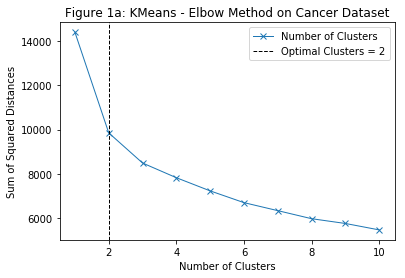

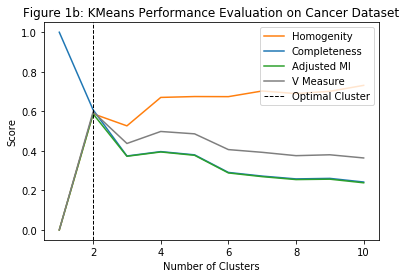

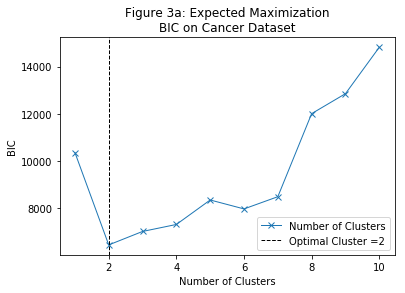

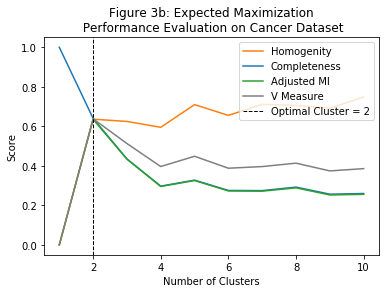

In [15]:
km_df1 = pd.read_csv("./Part1/Cancer_Cluster_Select_Kmeans.csv", header='infer')
em_df1 = pd.read_csv("./Part1/Cancer_Cluster_Select_GMM.csv", header='infer')

homo_df1 = pd.read_csv("./Part1/cancer_homo.csv", header = 'infer')
compl_df1 = pd.read_csv("./Part1/cancer_compl.csv", header = 'infer')
adjmi_df1 = pd.read_csv("./Part1/cancer_adjMI.csv", header = 'infer')

complete_df1 = pd.read_csv("./Part1/cancer_complete.csv", header = 'infer')
vmeasure_df1 = pd.read_csv("./Part1/cancer_vmeasure.csv", header = 'infer')

x_data = homo_df1['Unnamed: 0']
plt.close()
#plt.figure(figsize = (12,8))
plt.plot(x_data, km_df1['Cancer'], 'bx-', color = 'tab:blue', linewidth = 1, label = "Number of Clusters" )
plt.axvline(x=2 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Clusters = 2")
plt.legend(loc='best')
plt.title("Figure 1a: KMeans - Elbow Method on Cancer Dataset")
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Distances");
plt.show()
plt.close()


#plt.figure(figsize = (12,8))
plt.plot(x_data, homo_df1['Kmeans'], color = 'tab:orange',  label = "Homogenity" )
plt.plot(x_data, compl_df1['Kmeans'], color = 'tab:blue',  label = "Completeness" )
plt.plot(x_data, adjmi_df1['Kmeans'], color = 'tab:green',  label = "Adjusted MI" )
plt.plot(x_data, vmeasure_df1['Kmeans'], color = 'tab:gray',  label = "V Measure" )
plt.axvline(x=2 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Cluster")

plt.legend(loc='upper right')
plt.title("Figure 1b: KMeans Performance Evaluation on Cancer Dataset")
plt.xlabel("Number of Clusters")
plt.ylabel("Score");
plt.show()
plt.close()


plt.plot(x_data, em_df1['Cancer BIC'], 'bx-', color = 'tab:blue', linewidth = 1, label = "Number of Clusters" )
plt.axvline(x=2 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Cluster =2")
plt.legend(loc='best')
plt.title("Figure 3a: Expected Maximization\nBIC on Cancer Dataset")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC");
plt.show()
plt.close()


#plt.figure(figsize = (12,8))
plt.plot(x_data, homo_df1['GMM'], color = 'tab:orange',  label = "Homogenity" )
plt.plot(x_data, compl_df1['GMM'], color = 'tab:blue',  label = "Completeness" )
plt.plot(x_data, adjmi_df1['GMM'], color = 'tab:green',  label = "Adjusted MI" )
plt.plot(x_data, vmeasure_df1['GMM'], color = 'tab:gray',  label = "V Measure" )
plt.axvline(x=2 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Cluster = 2")
plt.legend(loc='upper right')
plt.title("Figure 3b: Expected Maximization\n Performance Evaluation on Cancer Dataset")
plt.xlabel("Number of Clusters")
plt.ylabel("Score");
plt.show()
plt.close()


In [148]:
random.seed(55)
nn_arga = [(25,),(25,25),(50),(50,50)]
nn_lr = [.001, .006, .01, .06, .1, .6]

#nn_arga = [(50)]
#nn_lr = [ 0.1]


##RP args
#best params =  {'NN__hidden_layer_sizes': 50, 'NN__learning_rate_init': 0.6, 'clf__n_components': 28}

##ICA args
#best params =  {'NN__hidden_layer_sizes': (50, 50), 'NN__learning_rate_init': 0.06, 'clf__n_components': 12}

##PCA args
#nn_arga = [(50,50)]
#nn_lr = [.06]
#best params =  {'NN__hidden_layer_sizes': (50, 50), 'NN__learning_rate_init': 0.06, 'clf__n_components': 14}
#best params =  {'NN__hidden_layer_sizes': (50, 50), 'NN__learning_rate_init': 0.01, 'clf__n_components': 18}



def run_NN(dims, clf, X, Y):
    grid ={'clf__n_components':dims,'NN__learning_rate_init':nn_lr,'NN__hidden_layer_sizes':nn_arga}      
    mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5)
    pipe = Pipeline([('clf',clf),('NN',mlp)])
    gs = GridSearchCV(pipe,grid,verbose=10,cv=10)
    gs.fit(X, Y)
    #print("components = ", clf.components_)

    print("best estimator = ", gs.best_estimator_)
    print("best params = ", gs.best_params_)
    
    return (pd.DataFrame(gs.cv_results_) , gs.best_estimator_)

In [20]:
def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]


In [21]:
def predict(X,y, layers, lr):
    mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5, 
                        hidden_layer_sizes = layers, learning_rate_init = lr )
    mlp.fit(X,y)
    y_pred = mlp.predict()
    
    return mlp.score(X,y)
    

In [22]:
# http://datascience.stackexchange.com/questions/6683/feature-selection-using-feature-importances-in-random-forests-with-scikit-learn          
class ImportanceSelect(BaseEstimator, TransformerMixin):
    def __init__(self, model, n=1):
         self.model = model
         self.n = n
    def fit(self, *args, **kwargs):
         self.model.fit(*args, **kwargs)
         return self
    def transform(self, X):
         return X[:,self.model.feature_importances_.argsort()[::-1][:self.n]]

### Dimension Reduction using PCA, ICA, RP and SVD

In [149]:
#%% Part 2A & 4A - Run Dimensionality Reduction Algorithm PCA, Run NN with reduced dims

plt.figure(figsize=(6,4))
print('Part 2A - Starting PCA for Cancer dataset')
pca = PCA(random_state=5)
pca.fit_transform(X_train)
explained_variance_ratio = pd.Series(data = pca.explained_variance_ratio_,index = range(1,31))
explained_variance_ratio.to_csv('./Part2/cancer_PCA_explained_variance_ratio.csv')
#print("final =", pca.components_)
explained_variance = pd.Series(data = pca.explained_variance_,index = range(1,31))
explained_variance.to_csv('./Part2/cancer_PCA_eigen_values.csv')


##run NN
pca = PCA(random_state=5)  
nn_results, clf = run_NN(dims_cancer, pca, X_train, Y_train)     
nn_results.to_csv('./Part4/cancer_PCA_nn_results.csv')

## test score

test_score = clf.score(X_test, Y_test)
print("Test Accuracy = ", test_score )
print("Best Estimator = ", clf)




Part 2A - Starting PCA for Cancer dataset
Fitting 10 folds for each of 696 candidates, totalling 6960 fits
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2, score=0.8043478260869565, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__le

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2, score=0.7608695652173914, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2, score=0.4, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2, score=0.5777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_ra

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3, score=0.6521739130434783, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3, score=0.6739130434782609, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3, score=0.5869565217391305, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3, score=0.6888888888888889, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3, score=0.7333333333333333, total=   0.0s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=7, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=7, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=8, score=0.6521739130434783, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=8, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=8, score=0.6304347826086957, total=   0.0s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=13, score=0.6521739130434783, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=13, score=0.7391304347826086, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=13, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=13, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=13, score=0.7333333333333333, total=   0.0s
[CV] NN__hid

[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=18, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=18, score=0.6304347826086957, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=18, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=18, score=0.5434782608695652, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=22, score=0.6956521739130435, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=22, score=0.782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=22, score=0.782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=22, score=0.6956521739130435, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=22, score=0.8695652173913043, total=   0.0s
[CV] NN__hidde

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=27, score=0.717391304347826, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=27, score=0.6304347826086957, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=27, score=0.717391304347826, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=27, score=0.391304347826087, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=27, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=3, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=3, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=3, score=0.7608695652173914, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=3, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=3, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=8, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=8, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=8, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=8, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=8, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=13, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=13, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=13, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=13, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=13, score=0.9565217391304348, total=   0.0s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=17, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=17, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=17, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=18, score=0.8043478260869565, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=18, score=0.9782608695652174, total=   0.0s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=22, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=22, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=22, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=22, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=22, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=26, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=26, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=26, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=27, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=27, score=0.8913043478260869, total=   0.0s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=30, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=2, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=2, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=2, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=2, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=

[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=6, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=6, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=6, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=6, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=6, 

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=11, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=11, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=11, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=11, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=11, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=15, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=15, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=15, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=15, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=15, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=20, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=20, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=20, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=20, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=20, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=24, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=24, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=24, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=24, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=24, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), N

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=28, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=28, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=28, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=28, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=28, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), N

[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=3, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=3, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=3, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=3, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=3, 

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=8, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=8, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=8, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=8, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=8, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learni

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=14, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=14, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=14, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=14, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=14, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=19, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=19, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=19, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=19, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=19, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), N

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=24, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=24, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=24, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=24, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=24, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), N

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=29, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=29, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=29, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=29, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=29, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=5, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=5, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=5, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=5, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=5, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=10, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=10, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=10, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=10, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=10, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(2

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=14, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=14, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=14, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=14, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=14, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learni

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=19, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=19, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=19, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=19, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=20, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=24, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=24, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=24, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=25, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=25, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learni

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=29, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=29, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=29, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=29, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=29, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learni

[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=4, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=5, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=5, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=5, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_component

[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=10, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=10, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=10, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=10, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=15, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=15, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=15, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=15, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=15, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learni

[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=20, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=20, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=20, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=21, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=25, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=25, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=25, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=26, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=26, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(2

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learni

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5, score=0.8888888888888888, total=  

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=9, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=9, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=9, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=9, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=10, score=0.8913043478260869, total

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=13, score=0.8260869565217391, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=13, score=0.7333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=13, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=13, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=13, score=0.7333333333333333,

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=17, score=0.7777777777777778, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=17, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=17, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=17, score=0.8666666666666667, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=17, score=0.8, total=   0.0s


[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=21, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=21, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=21, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=21, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=22, score=0.6086956521739131,

[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=26, score=0.8043478260869565, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=26, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=26, score=0.7391304347826086, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=26, score=0.6739130434782609, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=26 
[CV]  NN__hidden_layer_siz

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=30, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=30, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=30, score=0.5434782608695652, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=30, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=30, score=0.6222222222222222

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=5, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=5, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=5, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=5, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=5, score=0.9111111111111111, total=  

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=9, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=10, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=10, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=10, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=10, score=0.9782608695652174, 

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=14, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=14, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=14, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=14, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=14, score=1.0, total=   0.0s


[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=18, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=18, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=18, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=18, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=18, score=0.9777777777777777, total=   0.0s


[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=22, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=22, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=22, score=0.8, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=22, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=26, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=26, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=26, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=26, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=26, score=0.8666666666666667,

[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=30, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=30, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=30, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=30, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN

[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=5, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=5, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=5, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=5, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__l

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=9, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=10, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=10, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=10, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=10, score=0.9782608695652174, total=   

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=14, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=14, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=14, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=14, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=14, score=1.0, total=   0.0s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=18, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=18, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=18, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=18, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=18, score=1.0, total=   0.0s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=22, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=23, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=23, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=23, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=23, score=0.9565217391304348, total=  

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=26, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=26, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=26, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=27, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=27, score=0.9782608695652174, total=  

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=30, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=30, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=30, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=30, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=30, score=0.9777777777777777, total=   0.0s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=6, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=6, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=6, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=6, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=6, score=0.9333333333333333, total=   0.0s
[CV

[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=10, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=10, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=10, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=10, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learnin

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=14, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=14, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=14, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=14, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=14, score=1.0, total=   0.0s
[CV] NN__

[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=18, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=18, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=18, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=18, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learnin

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=22, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=22, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=23, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=23, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=23, score=0.9347826086956522, total=   0.0s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=27, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=27, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=27, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=27, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=27, score=1.0, total=   0.0s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=2, score=0.8260869565217391, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=2, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=2, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=2, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=2, score=0.9555555555555556, total=   0.0s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=6, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=6, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=6, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=6, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=6, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=10, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=10, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=10, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=10, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=10, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=14, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=14, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=15, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=15, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=15, score=0.9782608695652174, total=   0.1s
[CV

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=19, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=19, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=19, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=19, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=20, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=24, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=24, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=24, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=24, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=24, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=29, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=29, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=29, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=29, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=29, score=0.9777777777777777, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=4, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=4, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=4, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=5, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=5, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes

[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=9, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=9, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=9, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=9, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_r

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=13, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=13, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=14, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=14, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=14, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=18, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=18, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=18, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=18, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=18, score=0.9333333333333333, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=23, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=23, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=23, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=23, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=23, score=0.9130434782608695, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=27, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=27, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=27, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=27, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=28, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=2, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=2, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=2, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=2, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=2, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=6, score=0.5777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=6, score=0.6, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=6, score=0.6444444444444445, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=6, score=0.6444444444444445, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=7, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, c

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=11, score=0.8695652173913043, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=11, score=0.08695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=11, score=0.08695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=11, score=0.13043478260869565, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=11, score=0.17391304347826086, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN_

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=15, score=0.8260869565217391, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=15, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=15, score=0.6739130434782609, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=15, score=0.7391304347826086, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=15, score=0.8043478260869565, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__lea

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=20, score=0.2608695652173913, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=20, score=0.13043478260869565, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=20, score=0.9130434782608695, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=20, score=0.1956521739130435, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=20, score=0.8, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_ini

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=24, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=24, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=24, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=24, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=25, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__lea

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=28, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=28, score=0.7111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=29, score=0.5217391304347826, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=29, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=29, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__lea

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=4, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=4, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=4, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=4, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=4, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, c

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=9, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=9, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=9, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=9, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=9, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, c

[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=13, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=13, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=14, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=14, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=18, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=18, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=18, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=18, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=19, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=23, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=23, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=23, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=23, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=23, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=28, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=28, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=28, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=28, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=28, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__lea

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=4, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=4, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=4, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=4, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=4, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_comp

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=8, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=8, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=8, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=8, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=8, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_comp

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=13, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=13, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=13, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=13, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=13, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, cl

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=18, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=18, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=18, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=18, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=19, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, cl

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=23, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=23, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=23, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=23, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=23, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=28, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=28, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=28, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=28, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=28, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, cl

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=4, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=4, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=4, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=4, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=4, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=9, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=9, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=9, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=9, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=9, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=13, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=13, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=13, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=13, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=13, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, cl

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=17, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=18, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=18, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=18, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=18, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=22, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=22, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=22, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=26, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, cl

[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=2, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=2, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=2, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=2, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=2, score=0.9333333333333333,

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=7, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=7, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=7, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=7, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=7, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=7 


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=11, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=12, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=12, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=12, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=12, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.

[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=16, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=16, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=16, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=17, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=17, score=0.9782608695652174, total=   0.0s
[CV] 

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=21, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=21, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=21, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=21, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=21, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_compo

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=25, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=25, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=26, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=26, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=26, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=30, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=30, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=30, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=30, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=30, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=30 
[CV] 

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=5, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=5, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=5, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=5, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=5, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=5 


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=9, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=9, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=9, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=9, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=9, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=10 

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=14, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=14, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=14, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=14, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=14, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_compo

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=18, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=18, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=18, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=18, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=19, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=19 
[CV] 

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=22, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=23, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=23, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=23, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=23, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_compo

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=27, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=27, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=27, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=27, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=27, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_compo

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=2, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=2, score=0.8, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=2, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=3, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=3, score=0.9565217391304348, total=   0.0s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=7, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=7, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=7, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=7, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=7, score=0.8888888888888888, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=11, score=0.9565217391304348, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=11, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=11, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=11, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=11, score=0.6222222222222222,

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=15, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=15, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=15, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=15, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=15, score=0.8444444444444444,

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=18, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=19, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=19, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=19, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=19, score=0.9565217391304348,

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=23, score=0.8260869565217391, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=23, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=23, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=23, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=23, score=0.7391304347826086,

[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=27, score=0.8260869565217391, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=27, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=27, score=0.8260869565217391, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=27, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=27 
[CV]  NN__hidden_layer_siz

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=2, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=2, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=2, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=2, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=2, score=0.8888888888888888, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=5, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=6, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=6, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=6, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=6, score=0.9565217391304348, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=10, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=10, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=10, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=10, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=10, score=0.9555555555555556, total=   0.0s


[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=14, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=14, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=14, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=14, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=15, score=0.9130434782608695, total=   0.0s


[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=19, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=19, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=19, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=19, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=19, score=0.9347826086956522,

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=23, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=23, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=23, score=0.8260869565217391, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=23, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=23, score=1.0, total=   0.0s


[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=27, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28, score=0.9347826086956522,

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=3, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=3, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=3, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=3, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=3, score=0.9777777777777777, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=7, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=7, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=7, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=7, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=7, score=1.0, total=   0.0s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=11, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=11, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=11, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=11, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=11, score=0.9555555555555556, total=   0.0s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=16, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=16, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=16, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=16, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=16, score=0.9130434782608695, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=20, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=20, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=20, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=20, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=20, score=0.9777777777777777, total=   0.0s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=24, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=24, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=24, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=24, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=24, score=0.9555555555555556, total=   0.0s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=29, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=29, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=29, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=29, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=29, score=0.9565217391304348, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=4, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=4, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=4, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=4, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=4, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=9, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=9, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=9, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=9, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=9, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=13, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=14, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=14, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=14, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=14, score=0.9565217391304348, total=   0.0s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=17, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=17, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=17, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=18, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=18, score=0.9782608695652174, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=22, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=22, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=22, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=22, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=23, score=0.9347826086956522, total=   0.0s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=27, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=27, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=27, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=27, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=27, score=0.9777777777777777, total=   0.0s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=2, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=2, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=2, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=2, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=2, score=0.9555555555555556, total=   0.0s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=6, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=6, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=6, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=6, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=6, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=10, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=11, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=11, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=11, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=11, score=1.0, total=   0.0s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=15, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=15, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=15, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=15, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=16, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=20, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=20, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=20, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=20, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=20, score=1.0, total=   0.0s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25, score=0.9111111111111111, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=29, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=29, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=30, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=30, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=30, score=0.9347826086956522, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=14, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=14, score=0.9782608695652174, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=17, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=17, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=18, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=18, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=18, score=0.9782608695652174, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=22, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=22, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=22, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=22, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=22, score=0.9111111111111111, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=26, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=26, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=26, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=26, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=26, score=1.0, total=   0.0s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=30, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=30, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=30, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=30, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=30, score=0.8913043478260869, total=   0.0s
[CV

[Parallel(n_jobs=1)]: Done 6960 out of 6960 | elapsed:  2.2min finished


['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']


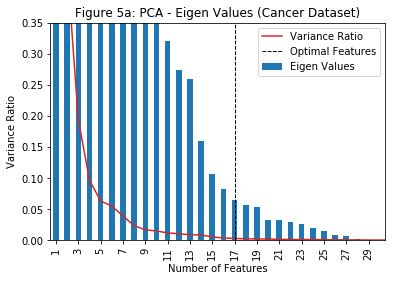

Reduced Dimension: 16 out of 30
Variance captured: 98.31999556922946 %


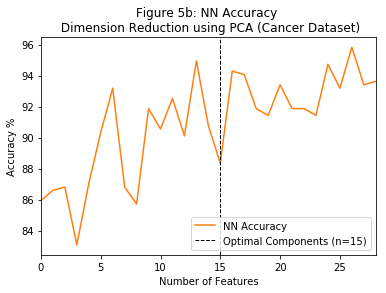

In [109]:
random.seed(55)
explained_variance_ratio.plot( ylim = (0.,0.35), color = 'tab:red',  label = "Variance Ratio" )
ax = explained_variance.plot(kind = 'bar',ylim = (0.,0.35),label = "Eigen Values")


ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::2])
ax.xaxis.set_ticklabels(ticklabels[::2]);
ax.axvline(x=16 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Features")

print(ticklabels)

plt.legend(loc='best')
plt.title("Figure 5a: PCA - Eigen Values (Cancer Dataset)")
plt.xlabel("Number of Features")
plt.ylabel("Variance Ratio");
plt.show()
plt.close()

print("Reduced Dimension: {} out of {}".
      format(X_train.shape[1]-len([i for i in explained_variance_ratio if i >= 0.005]),X_train.shape[1]))
print("Variance captured: {} %".format(sum([i for i in explained_variance_ratio if i >= 0.005])*100.))

nn_results_pca = pd.read_csv("./Part4/cancer_PCA_nn_results.csv", header = 'infer')
nn_results_pca = nn_results['mean_test_score'] * 100.0
#nn_train_results_pca = nn_results['mean_train_score'] * 100.0

nn_results_pca.plot( color = 'tab:orange',  label = "NN Accuracy" )
#nn_train_results_pca.plot( color = 'tab:green',  label = "NN Train Accuracy" )
plt.axvline(x=15 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Components (n=15)")

plt.legend(loc='best')
plt.title("Figure 5b: NN Accuracy \n Dimension Reduction using PCA (Cancer Dataset)")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy %");
plt.show()
plt.close()


### ICA Algorithm

In [82]:
dims_cancer

range(2, 31)

In [95]:
## Part 2 - DR algorithm ICA
random.seed(55)
print('Part 2B Starting ICA for cancer dataset')
ica = FastICA(random_state=5)
kurt = {}
svm = {}
for dim in dims_cancer:
    ica.set_params(n_components=dim)
    tmp = ica.fit_transform(X_train)
    tmp = pd.DataFrame(tmp)
    tmp2 = tmp.kurt(axis=0)
    kurt[dim] = tmp2.abs().mean()
  
kurt = pd.Series(kurt) 
kurt.to_csv('./Part2/cancer_ICA_kurtosis.csv')

print(kurt)




Part 2B Starting ICA for cancer dataset
2      1.672752
3      4.673760
4      5.058346
5      6.848297
6      7.144830
7      9.686014
8      9.970215
9     13.862775
10    14.449423
11    18.406321
12    20.420085
13    19.832304
14    19.201025
15    20.617874
16    21.121126
17    23.709483
18    24.927332
19    25.199972
20    25.958944
21    27.154128
22    27.014284
23    27.365593
24    29.511803
25    30.829743
26    30.454951
27    30.136703
28    31.048780
29    32.279145
30    32.846959
dtype: float64


In [150]:
# Run Neural Networks
ica = FastICA(random_state=5)  
nn_results , clf = run_NN(dims_cancer, ica, X_train, Y_train)     
nn_results.to_csv('./Part4/cancer_ICA_nn_results.csv')

## test score

test_score = clf.score(X_test, Y_test)
print("Test Accuracy = ", test_score )
print("Best Estimator = ", clf)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


Fitting 10 folds for each of 696 candidates, totalling 6960 fits
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3, score=0.391304347826087, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3, score=0.391304347826087, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_laye

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=7, score=0.391304347826087, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=7, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=7, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=7, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=7, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=11, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=11, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=11, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=11, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=11, score=0.6222222222222222, total=   0.0s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=15, score=0.6304347826086957, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=15, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=15, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=15, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=15, score=0.6222222222222222, total=   0.0s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=19, score=0.5111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=19, score=0.6444444444444445, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=19, score=0.6666666666666666, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=19, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=19, score=0.6666666666666666, total=   0.1s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=23, score=0.37777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=23, score=0.37777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=23, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=24, score=0.6739130434782609, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=24, score=0.8478260869565217, total=   0.2s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=27, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=27, score=0.37777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=27, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=27, score=0.37777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=27, score=0.37777777777777777, total=   0.1s
[CV] NN

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=3, score=0.6304347826086957, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=3, score=0.6739130434782609, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=3, score=0.6521739130434783, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=3, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=3, score=0.6888888888888889, total=   0.0s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=7, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=7, score=0.7608695652173914, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=7, score=0.7608695652173914, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=7, score=0.6739130434782609, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=7, score=0.7333333333333333, total=   0.0s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=11, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=11, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=11, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=12, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=12, score=0.6086956521739131, total=   0.0s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=15, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=16, score=0.6304347826086957, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=16, score=0.6304347826086957, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=16, score=0.6521739130434783, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=16, score=0.6521739130434783, total=   0.0s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=19, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=19, score=0.7111111111111111, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=20, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=20, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=20, score=0.6086956521739131, total=   0.0s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=24, score=0.6956521739130435, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=24, score=0.6739130434782609, total=   0.2s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=24, score=0.6956521739130435, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=24, score=0.6521739130434783, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=24, score=0.6739130434782609, total=   0.0s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=27, score=0.5777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=27, score=0.3333333333333333, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=28, score=0.6304347826086957, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=28, score=0.717391304347826, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=28, score=0.8913043478260869, total=   0.1s
[CV] NN__hidd

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=3, score=0.391304347826087, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=3, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=3, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=3, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=3, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=7, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=7, score=0.6521739130434783, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=7, score=0.7608695652173914, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=7, score=0.7608695652173914, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=7, score=0.6521739130434783, total=   0.0s
[CV] NN__hidden_layer_sizes=(2

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=11, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=11, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=11, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=11, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=12, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=16, score=0.6304347826086957, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=16, score=0.6739130434782609, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=16, score=0.5652173913043478, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=16, score=0.6739130434782609, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=16, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=20, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=20, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=20, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=20, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=20, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=24, score=0.6666666666666666, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=24, score=0.7111111111111111, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=24, score=0.7333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=24, score=0.6666666666666666, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=25, score=0.7608695652173914, total=   0.0s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=28, score=0.5777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=28, score=0.37777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=29, score=0.7608695652173914, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=29, score=0.391304347826087, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=29, score=0.391304347826087, total=   0.1s
[CV] NN__hidden_layer_

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=4, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=4, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=4, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=4, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=4, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(2

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=9, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=9, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=9, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=9, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=9, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(2

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=13, score=0.9130434782608695, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=13, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=13, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=13, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=13, score=0.7555555555555555, total=   0.0s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=17, score=0.8695652173913043, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=17, score=0.9130434782608695, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=17, score=0.9347826086956522, total=   0.2s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=17, score=0.9782608695652174, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=17, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=20, score=0.9111111111111111, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=21, score=0.9347826086956522, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=21, score=0.9347826086956522, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=21, score=0.9347826086956522, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=21, score=0.9130434782608695, total=   0.1s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=24, score=0.9111111111111111, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=24, score=0.9111111111111111, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=25, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=25, score=0.9347826086956522, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=25, score=0.9565217391304348, total=   0.2s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=28, score=0.9111111111111111, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=29, score=0.7391304347826086, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=29, score=0.7608695652173914, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=29, score=0.8043478260869565, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=29, score=0.782608695652174, total=   0.1s
[CV] NN__hidden_layer_

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=4, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=4, score=0.6888888888888889, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=4, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=4, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=4, score=0.8, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_i

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=9, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=9, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=9, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=9, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=9, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=13, score=0.9130434782608695, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=13, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=13, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=13, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=13, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=(2

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=17, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=17, score=0.9347826086956522, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=17, score=0.9782608695652174, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=17, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=17, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(2

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=21, score=0.8913043478260869, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=21, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=21, score=1.0, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=21, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=21, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learni

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=25, score=0.8888888888888888, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=25, score=1.0, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=25, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=25, score=0.9777777777777777, total=   0.2s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=25, score=0.9333333333333333, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learni

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=29, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=29, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=30, score=0.8695652173913043, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=30, score=0.9782608695652174, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=30, score=0.9565217391304348, total=   0.1s
[CV] NN__hidden_layer_sizes=(2

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=5, score=0.782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=5, score=0.6304347826086957, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=5, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=5, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=5, score=0.6888888888888889, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_in

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=9, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=9, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=9, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=9, score=0.7555555555555555, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=10, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=13, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=14, score=0.8260869565217391, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=14, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=14, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=14, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(2

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=17, score=0.9777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=17, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=18, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=18, score=0.9565217391304348, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=18, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(2

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=21, score=0.9555555555555556, total=   0.2s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=22, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=22, score=0.9347826086956522, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=22, score=0.782608695652174, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=22, score=0.9347826086956522, total=   0.1s
[CV] NN__hidden_layer_sizes=(25

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=25, score=0.9777777777777777, total=   0.2s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=25, score=0.9333333333333333, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=26, score=0.9130434782608695, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=26, score=0.9347826086956522, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=26, score=0.9347826086956522, total=   0.2s
[CV] NN__hidden_layer_sizes=(2

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=29, score=0.9777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=29, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30, score=0.8695652173913043, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30, score=0.9782608695652174, total=   0.1s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30, score=0.9347826086956522, total=   0.1s
[CV] NN__hidden_layer_sizes=(2

[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25, 2

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=9, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=9, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=10, score=0.5652173913043478, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=10, score=0.8043478260869565, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=10, score=0.8695652173913043, 

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=14, score=0.391304347826087, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=14, score=0.391304347826087, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=14, score=0.391304347826087, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=14, score=0.391304347826087, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=14, score=0.391304347826087, tota

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=17, score=0.37777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=17, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=18, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=18, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=18, score=0.608695652173913

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=21, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=21, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=21, score=0.6222222222222222, total=   0.2s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=22, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=22, score=0.6086956521739131,

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=25, score=0.37777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=25, score=0.37777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=25, score=0.37777777777777777, total=   0.2s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=25, score=0.37777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=26, score=0.6086956521739

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=29, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=29, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=29, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=29, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=29, score=0.6222222222222222,

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=5, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=5, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=5, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=5, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=5, score=0.6222222222222222, total=  

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=9, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=9, score=0.6304347826086957, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=9, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=9, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=9, score=0.6222222222222222, total=  

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=13, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=13, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=13, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=13, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=13, score=0.6222222222222222,

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=17, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=17, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=17, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=17, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=17, score=0.6222222222222222,

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=21, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=21, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=21, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=21, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=21, score=0.6222222222222222,

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=25, score=0.6086956521739131, total=   0.2s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=25, score=0.6956521739130435, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=25, score=0.6304347826086957, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=25, score=0.6666666666666666, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=25, score=0.6222222222222222,

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=29, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=29, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=29, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=29, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=29, score=0.6086956521739131,

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=4, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=4, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=4, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=4, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=4, score=0.6222222222222222, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=8, score=0.7555555555555555, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=8, score=0.6888888888888889, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=8, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=8, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=8, score=0.6222222222222222, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=12, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=12, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=12, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=12, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=12, score=0.6222222222222222, total=  

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=16, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=16, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=16, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=16, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=16, score=0.6222222222222222, total=  

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=20, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=20, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=20, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=20, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=21, score=0.6086956521739131, total=  

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=24, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=24, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=24, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=24, score=0.6444444444444445, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=25, score=0.6521739130434783, total=  

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=28, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=28, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=28, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=28, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=29, score=0.6086956521739131, total=  

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=4, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=4, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=4, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=4, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=4, score=0.6222222222222222, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=8, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=8, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=8, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=8, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=8, score=0.6222222222222222, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=12, score=1.0, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=12, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=12, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=12, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=13, score=0.9130434782608695, total=   0.0s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=16, score=1.0, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=16, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=16, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=16, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=17, score=0.8913043478260869, total=   0.1s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=20, score=1.0, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=20, score=0.9777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=20, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=20, score=0.8888888888888888, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=21, score=0.9565217391304348, total=   0.1s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=24, score=0.9111111111111111, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=24, score=0.9777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=24, score=0.9777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=24, score=1.0, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=24, score=0.9777777777777777, total=   0.1s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=28, score=0.9130434782608695, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=28, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=28, score=1.0, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=28, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=28, score=0.8888888888888888, total=   0.1s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=3, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=3, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=3, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=3, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=3, score=0.6222222222222222, total=   0.0s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=7, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=7, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=7, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=7, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=8, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=11, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=11, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=11, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=11, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=12, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=15, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=15, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=15, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=15, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=16, score=0.9130434782608695, total=   0.1s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=19, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=19, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=19, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=20, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=20, score=0.9782608695652174, total=   0.1s
[CV

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=23, score=0.9333333333333333, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=23, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=23, score=0.9333333333333333, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=24, score=0.9130434782608695, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=24, score=0.9782608695652174, total=   0.2s
[CV

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=27, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=27, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=27, score=0.8888888888888888, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=28, score=0.9565217391304348, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=28, score=0.9782608695652174, total=   0.1s
[CV

[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=2, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=2, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=2, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=3, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=6, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=7, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=7, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=7, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=7, score=0.6086956521739131, total=   0.0s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=11, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=11, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=11, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=11, score=0.8043478260869565, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=11, score=0.7111111111111111, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=14, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=15, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=15, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=15, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=15, score=0.6086956521739131, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=19, score=0.5869565217391305, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=19, score=0.9782608695652174, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=19, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=19, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=19, score=0.8913043478260869, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=22, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=22, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=23, score=0.9565217391304348, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=23, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=23, score=0.717391304347826, total=   0.1s
[CV]

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=26, score=0.9333333333333333, total=   0.2s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=26, score=0.7333333333333333, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=27, score=0.6521739130434783, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=27, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=27, score=0.9347826086956522, total=   0.1s
[CV

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=30, score=0.37777777777777777, total=   0.2s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=30, score=0.37777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=2, score=0.6956521739130435, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=2, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=2, score=0.8043478260869565, total=   0.0s
[CV] NN__hidden_layer_sizes=50,

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=6, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=6, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=6, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=6, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=6, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=10, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=10, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=10, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=10, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=11, score=0.6304347826086957, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN_

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=15, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=15, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=15, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=15, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=15, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__lea

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=19, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=19, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=19, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=19, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=19, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__lea

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=23, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=23, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=23, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=24, score=0.3695652173913043, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=24, score=0.391304347826087, total=   0.2s
[CV] NN__hidden_layer_sizes=50, NN__lear

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=28, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=28, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=28, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=28, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=28, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__lea

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=3, score=0.7391304347826086, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=3, score=0.8043478260869565, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=3, score=0.8043478260869565, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=3, score=0.8260869565217391, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=3, score=0.6888888888888889, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=8, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=8, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=8, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=8, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=8, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=12, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=12, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=12, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=12, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=12, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__lea

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=16, score=0.782608695652174, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=16, score=0.8222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=16, score=0.8222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=16, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=16, score=0.7555555555555555, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__lear

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=20, score=0.7777777777777778, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=20, score=0.7555555555555555, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=21, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=21, score=0.6304347826086957, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=21, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__lea

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=25, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=25, score=0.6086956521739131, total=   0.2s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=25, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=25, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=25, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__lea

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=29, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=29, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=29, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=29, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=29, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__lea

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=4, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=4, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=4, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=4, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=5, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=9, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=9, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=9, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=9, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=9, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=13, score=0.6888888888888889, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=14, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=14, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=14, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=14, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=18, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=18, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=18, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=18, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=18, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=22, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=22, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=22, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=22, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=22, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=26, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=26, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=26, score=0.6222222222222222, total=   0.2s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=26, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=27, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=30, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=30, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=30, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=30, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=2, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=6, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=6, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=6, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=6, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=6, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_comp

[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=10, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=10, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=10, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=10, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=11, score=0.869565217391

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=15, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=15, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=15, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=15, score=0.9565217391304348, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=15, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=19, score=0.9347826086956522, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=19, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=19, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=19, score=1.0, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=19, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, cl

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23, score=1.0, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23, score=0.9777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, cl

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27, score=0.8888888888888888, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27, score=1.0, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27, score=0.9777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27, score=0.9111111111111111, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27, score=0.8888888888888888, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, cl

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=2, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=3, score=0.8260869565217391, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=3, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=3, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=3, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=7, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=7, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=7, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=7, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=8, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=8 
[CV]  NN__hidde

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=11, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=11, score=0.8, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=12, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=12, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=12, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_compo

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=16, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=16, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=16, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=16, score=0.9130434782608695, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=16, score=0.8888888888888888, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=20, score=0.8222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=20, score=0.9777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=20, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=20, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=20, score=0.8666666666666667, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=24, score=0.9333333333333333, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=25, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=25, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=25, score=0.9347826086956522, total=   0.2s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=25, score=0.9347826086956522, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=29, score=0.8695652173913043, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=29, score=0.9347826086956522, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=29, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=29, score=0.9565217391304348, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=29, score=0.8666666666666667, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=4, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=4, score=0.8043478260869565, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=4, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=4, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=4, score=0.7777777777777778, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n

[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=8, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=8, score=0.8, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=8, score=0.8, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=8, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=8, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=12, score=0.7777777777777778, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=12, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=13, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=13, score=0.9130434782608695, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=13, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=17, score=0.7608695652173914, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=17, score=0.9347826086956522, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=17, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=17, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=17, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_compo

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=21, score=0.9347826086956522, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=21, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=21, score=1.0, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=21, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=21, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_compo

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=25, score=0.8888888888888888, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=25, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=25, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=25, score=0.9777777777777777, total=   0.2s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=25, score=0.9111111111111111, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=29, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=29, score=0.9333333333333333, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=29, score=0.9111111111111111, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=29, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=30, score=0.8043478260869565, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=4, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=5, score=0.6521739130434783, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=5, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=5, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=5, score=0.6304347826086957, total= 

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=8, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=8, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=9, score=0.5869565217391305, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=9, score=0.6521739130434783, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=9, score=0.6521739130434783, total=

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=12, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=13, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=13, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=13, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=13, score=0.6086956521739131,

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=16, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=16, score=0.6888888888888889, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=16, score=0.6, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=17, score=0.5869565217391305, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=17, score=0.5652173913043478, total=   0.0s


[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=20, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=20, score=0.37777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=20, score=0.37777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=20, score=0.37777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=20, score=0.3777777777777

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=24, score=0.6444444444444445, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=24, score=0.6888888888888889, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=24, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=24, score=0.6444444444444445, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=24, score=0.6444444444444445,

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=28, score=0.6304347826086957, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=28, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=28, score=0.6444444444444445, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=28, score=0.6888888888888889, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=28, score=0.6888888888888889,

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=4, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=4, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=4, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=4, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=4, score=0.6086956521739131, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=8, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=8, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=8, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=8, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=9, score=0.6086956521739131, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=12, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=12, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=12, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=13, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=13, score=0.6086956521739131,

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=16, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=16, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=16, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=16, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=17, score=0.6086956521739131,

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=20, score=0.6739130434782609, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=20, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=20, score=0.6444444444444445, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=20, score=0.6444444444444445, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=20, score=0.7111111111111111,

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=24, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=24, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=24, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=24, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=24, score=0.6222222222222222,

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28, score=0.6304347826086957, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28, score=0.6, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28, score=0.6222222222222222, total=   0.1s


[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=3, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=3, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=3, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=3, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=3, score=0.6222222222222222, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=7, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=7, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=7, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=7, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=7, score=0.4, total=   0.0s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=11, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=11, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=11, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=12, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=12, score=0.6086956521739131, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=15, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=16, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=16, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=16, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=16, score=0.6086956521739131, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=19, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=20, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=20, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=20, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=20, score=0.6086956521739131, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=23, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=24, score=0.6304347826086957, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=24, score=0.6086956521739131, total=   0.3s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=24, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=24, score=0.6086956521739131, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=27, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=27, score=0.6222222222222222, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=28, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=28, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=28, score=0.6086956521739131, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=2, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=2, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=2, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=2, score=0.7333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=3, score=0.6304347826086957, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=6, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=7, score=0.782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=7, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=7, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=7, score=0.8695652173913043, total=   0.0s
[CV]

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=10, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=10, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=10, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=11, score=0.6304347826086957, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=11, score=0.6521739130434783, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=14, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=14, score=0.9333333333333333, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=14, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=15, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=15, score=0.9565217391304348, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=18, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=18, score=1.0, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=18, score=0.9111111111111111, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=18, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=18, score=0.8888888888888888, total=   0.1s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=22, score=0.9130434782608695, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=22, score=0.8913043478260869, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=22, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=22, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=22, score=0.9555555555555556, total=   0.0s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=26, score=0.9782608695652174, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=26, score=0.9565217391304348, total=   0.2s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=26, score=0.9347826086956522, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=26, score=0.9347826086956522, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=26, score=0.8666666666666667, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=30, score=0.9565217391304348, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=30, score=0.9782608695652174, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=30, score=0.9782608695652174, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=30, score=0.9347826086956522, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=30, score=0.8695652173913043, total=  

[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=5, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=5, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=5, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=5, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_r

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=9, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=9, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=9, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=9, score=0.7777777777777778, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=10, score=0.9130434782608695, total=   0.0s
[CV] NN__h

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=13, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=13, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=13, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=14, score=0.9565217391304348, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=14, score=0.9565217391304348, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=17, score=0.9777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=17, score=0.7111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=17, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=17, score=0.7777777777777778, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=18, score=0.9347826086956522, total=   0.0s
[CV

[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=21, score=1.0, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=21, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=21, score=0.9777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=21, score=0.9555555555555556, total=   0.2s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_in

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25, score=0.8, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25, score=1.0, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25, score=0.9777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25, score=1.0, total=   0.2s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25, score=0.9111111111111111, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learni

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=29, score=0.8666666666666667, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=29, score=1.0, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=29, score=0.9777777777777777, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=29, score=1.0, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=29, score=0.9333333333333333, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5, score=0.6086956521739131, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5, score=0.782608695652174, total=   0.0s
[CV] NN__hidd

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9, score=0.7608695652173914, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9, score=0.6222222222222222, total=   0.0s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13, score=0.8913043478260869, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13, score=0.8260869565217391, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13, score=0.6086956521739131, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=16, score=0.9333333333333333, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=17, score=0.8913043478260869, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=17, score=0.782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=17, score=0.9782608695652174, total=   0.2s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=17, score=0.9130434782608695, total=   0.1s
[CV]

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=20, score=0.9333333333333333, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=21, score=0.9347826086956522, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=21, score=0.5652173913043478, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=21, score=0.9565217391304348, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=21, score=0.6086956521739131, total=   0.1s
[CV

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=24, score=0.7111111111111111, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=24, score=0.8666666666666667, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=25, score=0.6739130434782609, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=25, score=0.9347826086956522, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=25, score=0.8260869565217391, total=   0.2s
[CV

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=28, score=0.9555555555555556, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=28, score=0.6444444444444445, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=28, score=0.8444444444444444, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=29, score=0.8260869565217391, total=   0.1s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=29, score=0.6086956521739131, total=   0.1s
[CV

[Parallel(n_jobs=1)]: Done 6960 out of 6960 | elapsed:  5.8min finished


In [103]:
kurt = pd.read_csv("./Part2/cancer_ICA_kurtosis.csv", header = None)


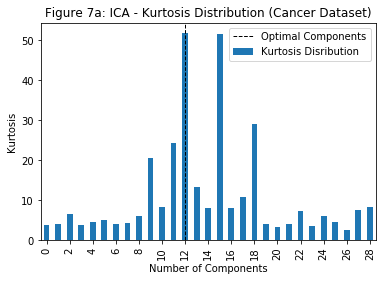

Reduced Dimension: 30 out of 30


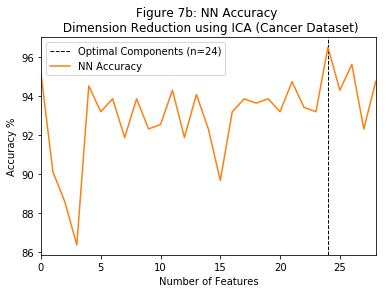

In [113]:
plt.figure(figsize=(6,4))
#kurt = pd.read_csv("./Part2/cancer_ICA_kurtosis.csv", header = 'None')
ax = kurt[1].plot(kind = 'bar', label = "Kurtosis Disribution");
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::2])
ax.xaxis.set_ticklabels(ticklabels[::2]);
ax.axvline(x=12 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Components")


plt.legend(loc='best')
plt.title("Figure 7a: ICA - Kurtosis Distribution (Cancer Dataset)")
plt.xlabel("Number of Components")
plt.ylabel("Kurtosis");
plt.show()
plt.close()
#print(kurt)

print("Reduced Dimension: {} out of {}".format(X_train.shape[1]-len([i for i in kurt if i >= 8.]),
                                               X_train.shape[1]))

###
#best estimator =  Pipeline(memory=None,
#     steps=[('clf', FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
#    n_components=12, random_state=5, tol=0.0001, w_init=None, whiten=True)), ('NN', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
#       beta_2=0.999, early_stopping=True, epsilon...       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
#       warm_start=False))])
#best params =  {'NN__hidden_layer_sizes': (50, 50), 'NN__learning_rate_init': 0.06, 'clf__n_components': 12}
###
nn_results_ica = pd.read_csv("./Part4/cancer_ICA_nn_results.csv", header = 'infer')
nn_results_ica = nn_results['mean_test_score'] * 100.0
#nn_train_results_pca = nn_results['mean_train_score'] * 100.0
plt.axvline(x=24 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Components (n=24)")

nn_results_ica.plot( color = 'tab:orange',  label = "NN Accuracy" )
#nn_train_results_pca.plot( color = 'tab:green',  label = "NN Train Accuracy" )

plt.legend(loc='best')
plt.title("Figure 7b: NN Accuracy \n Dimension Reduction using ICA (Cancer Dataset)")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy %");
plt.show()
plt.close()




### Dimension reduction using Random Projection

In [124]:
print('Part 2 - Starting RP, pairwise distance correlation, for cancer...')
tmp = defaultdict(dict)
for i,dim in product(range(10),dims_cancer):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(X_train), X_train)

tmp = pd.DataFrame(tmp).T
tmp.to_csv('./Part2/cancer_RP_pairwise_distance_corr.csv')


Part 2 - Starting RP, pairwise distance correlation, for cancer...


In [ ]:
# Run Neural Networks
rp = SparseRandomProjection(random_state=5) 
nn_results, clf = run_NN(dims_cancer, rp,  X_train, Y_train)     
nn_results.to_csv('./Part4/cancer_RP_nn_results.csv')

## test score

test_score = clf.score(X_test, Y_test)
print("Test Accuracy = ", test_score )
print("Best Estimator = ", clf)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s


Fitting 10 folds for each of 696 candidates, totalling 6960 fits
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2, score=0.5869565217391305, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2, score=0.3695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2, score=0.5, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hi

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3, score=0.6739130434782609, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3, score=0.6739130434782609, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3, score=0.5652173913043478, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3, score=0.717391304347826, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=3, score=0.5777777777777777, total=   0.0s
[CV] NN__hidden_layer_

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=8, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=8, score=0.717391304347826, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=8, score=0.5869565217391305, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=8, score=0.7391304347826086, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=8, score=0.7777777777777778, total=   0.0s
[CV] NN__hidden_layer_

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=12, score=0.717391304347826, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=12, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=12, score=0.717391304347826, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=12, score=0.717391304347826, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=12, score=0.7111111111111111, total=   0.0s
[CV] NN__hidden

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=16, score=0.7391304347826086, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=16, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=16, score=0.782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=16, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=16, score=0.5777777777777777, total=   0.0s
[CV] NN__hidd

[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=21, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=21, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=21, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=21, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=25, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=25, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=25, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=25, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=25, score=0.8444444444444444, total=   0.0s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=30, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=30, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=30, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=30, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.001, clf__n_components=30, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=6, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=6, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=6, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=6, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=6, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=10, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=11, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=11, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=11, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=11, score=0.9782608695652174, total=   0.0s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=15, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=15, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=15, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=15, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=15, score=0.8913043478260869, total=   0.0s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=18, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=19, score=0.8043478260869565, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=19, score=0.8260869565217391, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=19, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=19, score=0.8913043478260869, total=   0.0s
[CV] NN__hid

[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=24, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=24, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=24, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=24, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate

[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=28, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=28, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=28, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=28, score=0.7555555555555555, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=3, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=3, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=3, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=3, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=3, score=0.7333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(2

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=8, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=8, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=8, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=8, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=8, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(2

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=13, score=0.8043478260869565, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=13, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=13, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=13, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=13, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=17, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=17, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=17, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=18, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=18, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=22, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=22, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=22, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=23, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=23, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=27, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=27, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=27, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=27, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.01, clf__n_components=27, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rat

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=3, score=0.8043478260869565, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=3, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=3, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=3, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=3, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(2

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=7, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=7, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=7, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=7, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=7, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(2

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=12, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=12, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=12, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=12, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=12, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=17, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=17, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=17, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=18, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=18, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), N

[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=22, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=22, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=22, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=23, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.0

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=27, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=27, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=27, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=27, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.06, clf__n_components=28, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), N

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=3, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=3, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=4, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=4, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=4, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=9, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=9, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=9, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=9, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=9, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=14, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=14, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=15, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=15, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=15, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(2

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=20, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=20, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=20, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=20, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=20, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learni

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=25, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=25, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=25, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=25, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=25, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=30, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=30, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=30, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=30, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.1, clf__n_components=30, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learni

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=6, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=7, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=7, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=7, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=7, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=10, score=0.8, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=10, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=11, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=11, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=11, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learni

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=15, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=15, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=15, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=16, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=16, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(2

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=20, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=20, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=20, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=20, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=21, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(2

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=25, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=25, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=25, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=25, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=25, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.

[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25,), NN__learning_rate_init=0.6, clf__n_components=30, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(2

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=5, score=0.9130434782608695, total=  

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=9, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=9, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=9, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=9, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=9, score=0.8888888888888888, total=  

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=13, score=0.8260869565217391, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=13, score=0.5217391304347826, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=13, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=13, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=13, score=0.8888888888888888, total=   0.0s


[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=17, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=17, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=17, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=17, score=0.6444444444444445, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=18, score=0.8913043478260869,

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=21, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=21, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=21, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=21, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=22, score=0.6086956521739131,

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=26, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=26, score=0.7777777777777778, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=26, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=26, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=26, score=0.8888888888888888,

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=30, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.001, clf__n_components=30, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=2, score=0.782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=2, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=2, score=0.9565217391304348, total=

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=6, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=6, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=6, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=7, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=7, score=0.8260869565217391, total=  

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=10, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=10, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=10, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=10, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=11, score=0.9347826086956522,

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=15, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=15, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=15, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=15, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=15, score=1.0, total=   0.0s


[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=19, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=19, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=20, score=0.782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=20, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=20, score=0.9565217391304348, 

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=24, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=24, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=24, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=24, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=24, score=0.8444444444444444,

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=28, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=28, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=28, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=28, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.006, clf__n_components=28, score=0.8695652173913043,

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=2, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=2, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=3, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=3, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=3, score=0.8913043478260869, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=7, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=7, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=7, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=7, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=7, score=0.8260869565217391, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=11, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=11, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=11, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=11, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=11, score=1.0, total=   0.0s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=15, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=16, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=16, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=16, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=16, score=0.9130434782608695, total=   0.0s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=20, score=0.8260869565217391, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=20, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=20, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=20, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=20, score=0.9347826086956522, total=  

[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=24, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=24, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=25, score=0.8260869565217391, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=25, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25, 2

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=29, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=29, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=29, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=29, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.01, clf__n_components=30, score=0.8913043478260869, total=   0.0s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=4, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=4, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=5, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=5, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=5, score=0.9347826086956522, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=9, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=9, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=9, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=9, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=9, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=12, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=13, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=13, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=13, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=13, score=0.9565217391304348, total=  

[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=17, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=17, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=17, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=17, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25, 2

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=22, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=22, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=22, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=22, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=22, score=0.9777777777777777, total=  

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=26, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=26, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=26, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=26, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=26, score=0.9555555555555556, total=   0.0s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=30, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=30, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=30, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.06, clf__n_components=30, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=2, score=0.8260869565217391, total=   0.0s
[CV] NN__hidden_layer_sizes=

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=5, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=6, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=6, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=6, score=0.8043478260869565, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=6, score=0.9347826086956522, total=   0.0s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=10, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=10, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=10, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=10, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=10, score=1.0, total=   0.0s
[CV] NN__hidden_la

[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=15, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=15, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=15, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=15, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_in

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=19, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=19, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=19, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=19, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=19, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=24, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=24, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=24, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=24, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=24, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=28, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=28, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=28, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=29, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.1, clf__n_components=29, score=0.9782608695652174, total=   0.0s
[CV

[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=3, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=3, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=4, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=4, score=0.8043478260869565, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_r

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=7, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=7, score=0.7555555555555555, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=7, score=0.5777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=8, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=8, score=0.9347826086956522, total=   0.0s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=12, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=12, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=12, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=12, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=12, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=17, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=17, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=17, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=17, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=17, score=0.9347826086956522, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=21, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=22, score=0.8260869565217391, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=22, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=22, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=22, score=0.9782608695652174, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=25, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=25, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=26, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=26, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=26, score=0.9130434782608695, total=   0.0s
[CV

[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=29, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=30, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=30, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=30, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(25, 25), NN__learning_rate_init=0.6, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(25, 25), NN__l

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=5, score=0.7555555555555555, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=5, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=5, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=5, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=5, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=9, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=10, score=0.6304347826086957, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=10, score=0.7608695652173914, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=10, score=0.7608695652173914, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=10, score=0.6739130434782609, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__lear

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=14, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=14, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=14, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=14, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=14, score=0.7777777777777778, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__lea

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=18, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=18, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=18, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=18, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=18, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__lea

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=22, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=22, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=22, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=23, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=23, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__lea

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=26, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=26, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=26, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=26, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=27, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__lea

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=30, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=30, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.001, clf__n_components=30, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=2, score=0.782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=2, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=6, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=6, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=6, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=6, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=6, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=11, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=11, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=11, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=11, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=11, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__lea

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=15, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=15, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=15, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=15, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=15, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__lea

[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=19, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=19, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=19, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=19, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=23, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=23, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=23, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=23, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=23, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__lea

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=27, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=27, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=27, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=27, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.006, clf__n_components=28, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=3, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=3, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=3, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=3, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=3, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=7, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=7, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=7, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=7, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=8, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_comp

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=12, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=12, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=12, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=12, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=12, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=16, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=16, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=16, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=16, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=16, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=20, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=20, score=0.7111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=20, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=21, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=21, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=24, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=24, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=24, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=25, score=0.8043478260869565, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=25, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, cl

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=29, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=29, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=29, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=29, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, clf__n_components=30, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.01, cl

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=4, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=4, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=4, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=5, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=5, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.

[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=8, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=9, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=9, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=9, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=9, score=0.9130434

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=13, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=13, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=13, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=14, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=14, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rat

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=18, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=18, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=18, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=18, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=18, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, cl

[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=23, score=0.913043478260

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=27, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components=28, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, clf__n_components

[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=3, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=3, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=3, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=4, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=4, score=0.9565217391304348,

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=8, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=8, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=8, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=9, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=9, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=13, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=13, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=13, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=14, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=14, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=18, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=18, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=18, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=18, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=18, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_compo

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=23, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=23, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=23, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=23, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=23, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_compo

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=28, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=28, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=28, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=28, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.1, clf__n_components=28, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=4, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=4, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=4, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=4, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=4, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=9, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=9, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=9, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=9, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=9, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=13, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=13, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=14, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=14, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=14 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=14, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=18, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=18, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=18, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=18, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=18 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=18, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_compo

[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=22, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=22, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=22, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=23, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=23 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=23, score=0.9565217

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=27, score=0.8260869565217391, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=27, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=27, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=27, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=27, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.6, clf__n_components=27 
[CV] 

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=2, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=2, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=2, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=2, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=2, score=0.8444444444444444, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=6, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=6, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=6, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=6 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=6, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=7 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=7, score=0.3695652173913043, total=  

[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=11, score=0.6086956521739131, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=11, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=11, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=11, score=0.6222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=11 
[CV]  NN__hidden_layer_siz

[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=16, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=16, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=16, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=16, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=16 
[CV]  NN__hidden_layer_siz

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=20, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=20, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=20, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=20, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=20, score=0.8478260869565217,

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=23, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=24, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=24, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=24, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=24, score=0.9565217391304348,

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=27, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=27, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=27 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=27, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=28, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.001, clf__n_components=28, score=0.9347826086956522,

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=3, score=0.8, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=3, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=3, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=3, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=3, score=0.9333333333333333, total=   0.0s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=8, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=8, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=8, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=8, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=8, score=0.9130434782608695, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=12, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=12, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=12, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=12, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=12, score=0.9333333333333333,

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=16, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=16, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=16, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=16, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=16, score=0.9111111111111111,

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=20, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=20, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=20, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=20, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=20, score=0.8222222222222222,

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=24, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=24, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=24, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=24, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=24, score=1.0, total=   0.0s


[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.006, clf__n_components=28, score=1.0, total=   0.0s


[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=4, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=4, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=4, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=4, score=0.8260869565217391, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=4, score=0.8666666666666667, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=9, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=9, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=9, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=9, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=9, score=0.8913043478260869, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=13, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=13, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=13, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=13, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=13, score=0.9777777777777777, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=17, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=17, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=17, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=17, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=17, score=0.9111111111111111, total=   0.0s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=21, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=21, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=21, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=22, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=22 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=22, score=0.9565217391304348, total=   0.0s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=25, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=25, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=25, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=25, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=26 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=26, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_si

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=30, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=30, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=30, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=30, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.01, clf__n_components=30, score=1.0, total=   0.0s
[CV] NN__

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=5, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=5, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=5, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=5, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=5, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=10, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=10, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=10, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=10, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=10, score=0.9777777777777777, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=15, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=15, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=15, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=15, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=15 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=15, score=0.9555555555555556, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=19, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=19, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=19, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=19 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=19, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=20, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_si

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=23, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=24, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=24, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=24, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=24 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=24, score=0.9565217391304348, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=28, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=28, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=28, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=28, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=28 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.06, clf__n_components=28, score=0.9555555555555556, total=  

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=3, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=3, score=0.8695652173913043, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=3, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=3, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=3 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=3, score=0.9333333333333333, total=   0.0s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=8, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=8, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=8, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=8, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=8 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=8, score=0.9111111111111111, total=   0.0s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=12, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=12, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=12 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=12, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=13, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=13, score=0.9782608695652174, total=   0.0s
[CV

[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=16, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=17, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=17, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=17, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__l

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=20, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=21, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=21, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=21, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=21, score=0.9782608695652174, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=25, score=0.9777777777777777, total=   0.0s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=29, score=0.8666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=29, score=1.0, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=29, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=29, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.1, clf__n_components=29, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=4, score=0.8, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=4 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=4, score=0.8444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=5, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=8, score=0.8888888888888888, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=9, score=0.8913043478260869, total=   0.0s
[CV] NN__hid

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=13, score=0.9347826086956522, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=16, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=16 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=16, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=17, score=0.8478260869565217, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=17, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=17 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=17, score=0.9347826086956522, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=20, score=0.9555555555555556, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=21, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=21, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=21, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=21 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=21, score=0.9347826086956522, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=25, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=25, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=25, score=0.8913043478260869, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=25, score=0.9111111111111111, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=25 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=25, score=0.9777777777777777, total=   0.0s
[CV

[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=29, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=29, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=29, score=0.9782608695652174, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=29, score=0.9130434782608695, total=   0.0s
[CV] NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=(50, 50), NN__learning_rate_init=0.6, clf__n_components=29, score=0.9333333333333333, total=   0.0s
[CV

[Parallel(n_jobs=1)]: Done 6960 out of 6960 | elapsed:  2.0min finished


In [115]:
def reconstructionError(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p@W)@(X.T)).T # Unproject projected data
    errors = np.square(X-reconstructed)
    return np.nanmean(errors)
 

In [116]:
tmp = defaultdict(dict)
for i,dim in product(range(10),dims_cancer):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    rp.fit(X_train)    
    tmp[dim][i] = reconstructionError(rp, X_train)
tmp =pd.DataFrame(tmp).T
tmp.to_csv('./Part2/cancer_RP_reconstruction_error.csv')


In [120]:
recon_error = pd.read_csv("./Part2/cancer_RP_reconstruction_error.csv", header = 'infer')
recon_error['10'].head()

0    0.978968
1    0.946148
2    0.921694
3    0.867677
4    0.860233
Name: 10, dtype: float64

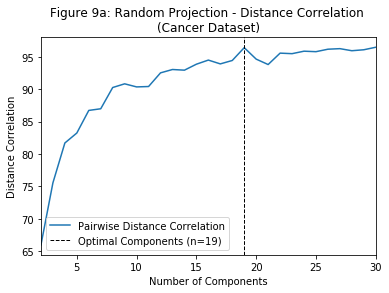

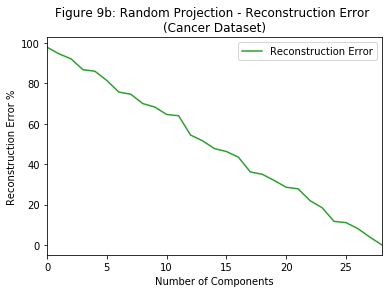

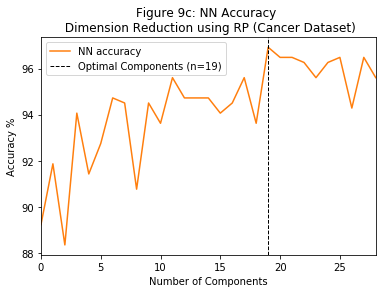

In [142]:
tmp['mean'] = tmp.mean(axis=1)

distance = tmp['mean']*100.0
t_recon = recon_error['10'] * 100.0

#t_recon.plot( color = 'tab:green',  label = "Reconstruction Error" )

distance.plot(color = 'tab:blue',  label = "Pairwise Distance Correlation" )
plt.axvline(x=19 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Components (n=19)")
recon_error = pd.read_csv("./Part2/cancer_RP_reconstruction_error.csv", header = 'infer')


plt.legend(loc='best')
plt.title("Figure 9a: Random Projection - Distance Correlation \n(Cancer Dataset)")
plt.xlabel("Number of Components")
plt.ylabel("Distance Correlation");
plt.show()
plt.close()

t_recon = recon_error['10'] * 100.0
t_recon.plot( color = 'tab:green',  label = "Reconstruction Error" )
plt.legend(loc='best')
plt.title("Figure 9b: Random Projection - Reconstruction Error \n(Cancer Dataset)")
plt.xlabel("Number of Components")
plt.ylabel("Reconstruction Error %");
plt.show()
plt.close()


nn_results_rp = pd.read_csv("./Part4/cancer_RP_nn_results.csv", header = 'infer')
nn_results_rp = nn_results['mean_test_score'] * 100.0
#nn_train_results_pca = nn_results['mean_train_score'] * 100.0
nn_results_rp.plot( color = 'tab:orange',  label = "NN accuracy" )
plt.axvline(x=19 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Components (n=19)")

plt.legend(loc='best')
plt.title("Figure 9c: NN Accuracy \n Dimension Reduction using RP (Cancer Dataset)")
plt.xlabel("Number of Components")
plt.ylabel("Accuracy %");
plt.show()
plt.close()




### Part 2 - Dimension reduction using Random Forest

In [54]:
print('*** Part 2 - Start Dimension Reduction for Cancer Dataset ***')

rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=5, n_jobs=7)

fs_cancer = rfc.fit(X_train, Y_train).feature_importances_ 

tmp = pd.Series(np.sort(fs_cancer)[::-1])
tmp.to_csv('./Part2/cancer_RF_feature_importance.csv')


*** Part 2 - Start Dimension Reduction for Cancer Dataset ***


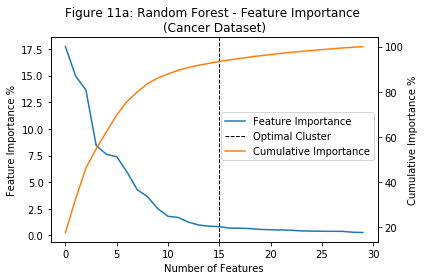

In [59]:
df1 = pd.read_csv("./Part2/cancer_RF_feature_importance.csv", header=None)
x_data = df1[0] 

plt.figure(figsize = (12,8))
fig, ax1 = plt.subplots()
ax1.plot(x_data, df1[1]* 100.0, label = "Feature Importance" , color = "tab:blue",)
ax1.axvline(x=15 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Cluster")
#reatins 90% feature importance
#plt.legend(loc='center right')

ax2 = ax1.twinx() 
ax2.plot(x_data, df1[2]*100.0, label = "Cumulative Importance" , color = "tab:orange",)

#ax1.legend(loc='center right')
fig.legend(loc='center left', bbox_to_anchor=(0.5, 0.5))
plt.title("Figure 11a: Random Forest - Feature Importance \n(Cancer Dataset)")
ax1.set_xlabel("Number of Features")
ax1.set_ylabel("Feature Importance %")
ax2.set_ylabel("Cumulative Importance %")
fig.tight_layout() 

plt.show()
plt.close()

In [ ]:
#nn_arga = [(25,),(25,25),(50),(50,50),(100,25,100)]
#nn_lr = [.001, .006, .01, .06, .1, .6, 1]

nn_arga = [(50)]
nn_lr = [0.06]

rfc = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=5,n_jobs=7)
filtr = ImportanceSelect(rfc)
grid ={'filter__n':dims_cancer,'NN__learning_rate_init':nn_lr,'NN__hidden_layer_sizes':nn_arga}  
mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5)
pipe = Pipeline([('filter',filtr),('NN',mlp)])
gs = GridSearchCV(pipe,grid,verbose=10,cv=10)
gs.fit(X_train, Y_train)
nn_results = pd.DataFrame(gs.cv_results_)
nn_results.to_csv('./Part4/cancer_RF_nn_results.csv')

print("best estimator = ", gs.best_estimator_)
print("best params = ", gs.best_params_)
    


Fitting 10 folds for each of 29 candidates, totalling 290 fits
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2, score=0.8478260869565217, total=   0.5s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2, score=0.9347826086956522, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2, score=0.9565217391304348, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2, score=0.9782608695652174, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.2s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2, score=0.8913043478260869, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.7s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2, score=0.9111111111111111, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.3s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2, score=0.9777777777777777, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.8s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2, score=0.9111111111111111, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.4s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2, score=0.9333333333333333, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.9s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=2, score=0.9555555555555556, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=3, score=0.8913043478260869, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=3, score=0.9565217391304348, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=3, score=0.9782608695652174, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=3, score=0.9565217391304348, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=7, score=0.9347826086956522, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=7 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=7, score=0.9130434782608695, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=7 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=7, score=0.9333333333333333, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=7 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=7, score=1.0, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=7 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=7, score=0.9111111111111111, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=7 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=11, score=0.9777777777777777, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=11 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=11, score=0.9333333333333333, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=11 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=11, score=0.9555555555555556, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=12, score=0.8695652173913043, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=12, score=0.9782608695652174, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=12 
[CV]  NN__hidden_layer_sizes=50, NN__learning

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=16, score=0.9782608695652174, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=16 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=16, score=0.9782608695652174, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=16 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=16, score=1.0, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=16 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=16, score=0.9565217391304348, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=16 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=16, score=0.9333333333333333, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=16 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=20, score=0.9333333333333333, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=20, score=0.9777777777777777, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=20, score=1.0, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=20, score=0.9555555555555556, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=20 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=20, score=0.9555555555555556, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=21 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=25, score=0.9782608695652174, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=25 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=25, score=0.9565217391304348, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=25 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=25, score=1.0, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=25 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=25, score=0.9782608695652174, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=25 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=25, score=0.9111111111111111, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=25 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=29, score=0.9111111111111111, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=29, score=1.0, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=29, score=0.9555555555555556, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=29, score=0.9555555555555556, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=29 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=29, score=0.9777777777777777, total=   0.4s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, filter__n=30 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06

[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:  5.8min finished


best estimator =  Pipeline(memory=None,
     steps=[('filter', ImportanceSelect(model=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
           ...       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False))])
best params =  {'NN__hidden_layer_sizes': 50, 'NN__learning_rate_init': 0.06, 'filter__n': 16}


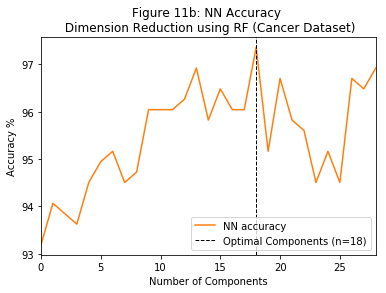

Test Accuracy =  0.973684210526
Best Estimator =  Pipeline(memory=None,
     steps=[('filter', ImportanceSelect(model=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
           ...       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False))])


In [61]:
nn_results_rf = pd.read_csv("./Part4/cancer_RF_nn_results.csv", header = 'infer')
nn_results_rf = nn_results['mean_test_score'] * 100.0
#nn_train_results_pca = nn_results['mean_train_score'] * 100.0
nn_results_rf.plot( color = 'tab:orange',  label = "NN accuracy" )
plt.axvline(x=18 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Components (n=18)")

plt.legend(loc='best')
plt.title("Figure 11b: NN Accuracy \n Dimension Reduction using RF (Cancer Dataset)")
plt.xlabel("Number of Components")
plt.ylabel("Accuracy %");
plt.show()
plt.close()

clf = gs.best_estimator_
## test score

test_score = clf.score(X_test, Y_test)
print("Test Accuracy = ", test_score )
print("Best Estimator = ", clf)

In [ ]:
tmp['mean'] = tmp.mean(axis=1)

distance = tmp['mean']*100.0

distance.plot(color = 'tab:blue',  label = "Pairwise Distance Correlation" )
plt.axvline(x=19 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Components")

plt.legend(loc='best')
plt.title("Figure 5c: Random Projection - Distane Correlation \n(Cancer Dataset)")
plt.xlabel("Number of Components")
plt.ylabel("Distance Correlation");
plt.show()
plt.close()

### Evaluate reconstruction error

In [ ]:
n_candidates = [int(features2.shape[1]*0.1*(i+1)) for i in range(10)]
reconstruct_pca_res2 = []
for i,n in enumerate(n_candidates):
    pca = PCA(n)
    temp = pca.fit_transform(features2)
    diff = features2.values - pca.inverse_transform(temp)
    reconstruct_pca_res2.append(["{} ({}%)".format(n,(i+1)*10),np.mean(diff),np.std(diff),np.max(diff),np.min(diff)])

### KMeans clusters

For n_clusters = 2 The average silhouette_score is : 0.337655250599
For n_clusters = 3 The average silhouette_score is : 0.31038091558
For n_clusters = 4 The average silhouette_score is : 0.268214965627
For n_clusters = 5 The average silhouette_score is : 0.27240997951


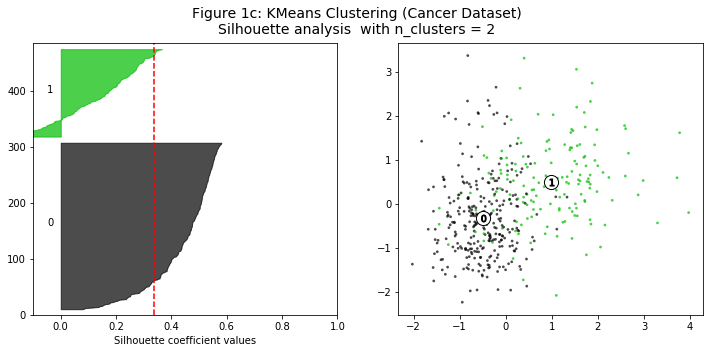

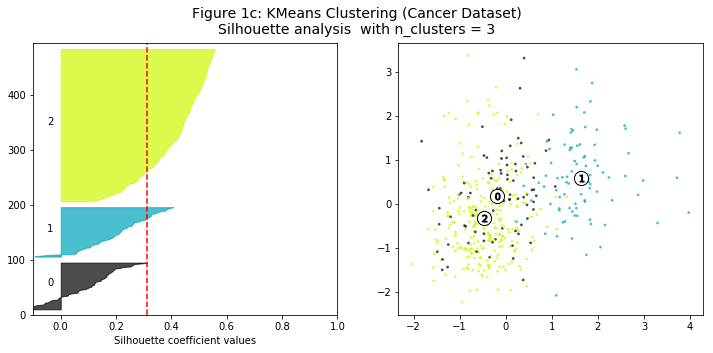

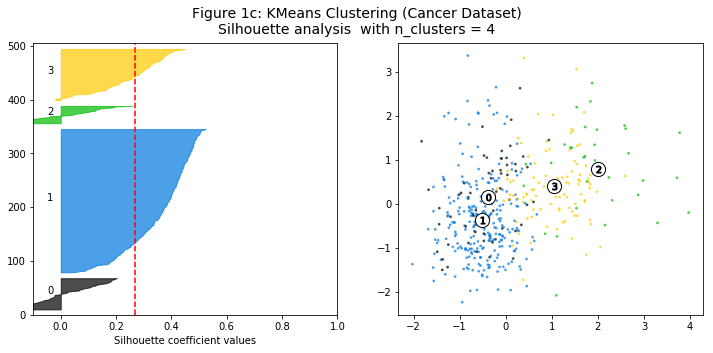

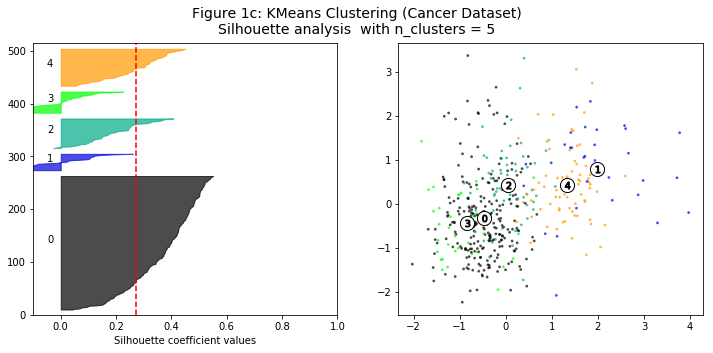

In [17]:
title = "Figure 1c: KMeans Clustering (Cancer Dataset)\n"
kmeans_silhoutte(X_train, Y_train, title)

BIC score =  6451.94500564
BIC scores =  [ 39660.84516472  33100.91375792  31436.05506516  30419.80478965
  29665.72640889  28865.99507001  28327.49496106  27720.9592547
  27677.09420953  10363.56757196  10319.12096837  10274.96131242
  10248.76320692  10232.29790467  10142.63267903   9162.86642819
  10000.59063025   8993.42103485  39829.43489076  31034.70480975
  29255.19153789  28029.37401948  27134.79513522  25864.80059577
  25171.83272552  25374.96356712  24744.42221599  10363.56757196
   6451.94500564   7008.55186339   8357.76549752   9291.35827057
   8351.10903522  10870.30672759  12854.58228265  11814.37216227]


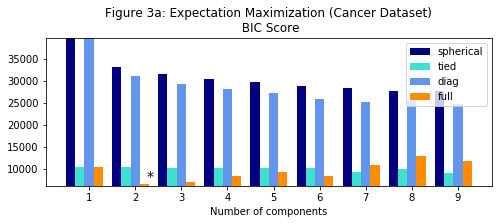

In [146]:
compute_bic_score(X_train, "Figure 3a: Expectation Maximization (Cancer Dataset)\n BIC Score" , "Figure 3b: Cluster Representation")

## Part 3 - Clustering with reduced dimensions

In [80]:
dim_PCA = 16 
dim_ICA = 15 
dim_RP = 19 
dim_RF = 18 

rfc = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', random_state =5, n_jobs = 7)

algo_name = ['PCA', 'ICA', 'RP', 'RF']

filter_ = ImportanceSelect(rfc,dim_RF)

algos = [PCA(n_components=dim_PCA,random_state=10), 
           FastICA(n_components=dim_ICA,random_state=10), 
           SparseRandomProjection(n_components=dim_RP,random_state=5),
           ImportanceSelect(rfc,dim_RF)]

for i in range(len(algos)):
    if i == 3:
        X2 = algos[i].fit_transform(X_train, Y_train)
    else:   
        X2 = algos[i].fit_transform(X_train)
    data2 = pd.DataFrame(np.hstack((X2,np.atleast_2d(Y_train).T)))
    cols = list(range(data2.shape[1]))
    cols[-1] = 'Class'
    data2.columns = cols
    data2.to_hdf('datasets.hdf','cancer_'+algo_name[i],complib='blosc',complevel=9)

### Run KMeans on reduced dataset

In [ ]:
PCA

For n_clusters = 2 The average silhouette_score is : 0.498047295624
For n_clusters = 3 The average silhouette_score is : 0.335288577422
    
ICA
For n_clusters = 2 The average silhouette_score is : 0.498047295624
For n_clusters = 3 The average silhouette_score is : 0.335288577422

RP


RF

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 'Class'], dtype='object')
For n_clusters = 2 The average silhouette_score is : 0.0949093035721
For n_clusters = 3 The average silhouette_score is : 0.0804395726164
For n_clusters = 4 The average silhouette_score is : 0.0725185385125
For n_clusters = 5 The average silhouette_score is : 0.0412736263806


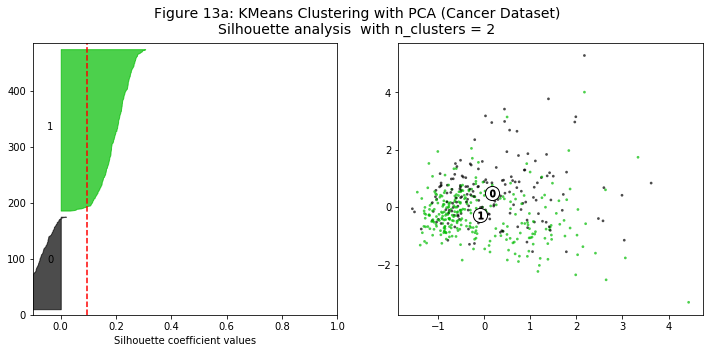

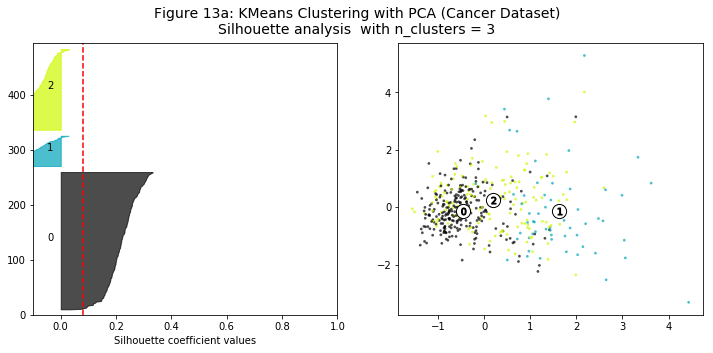

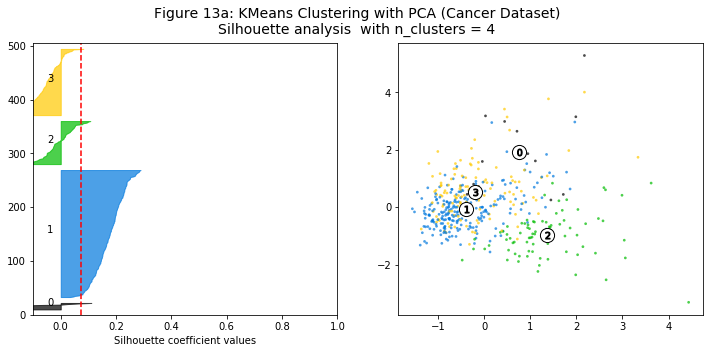

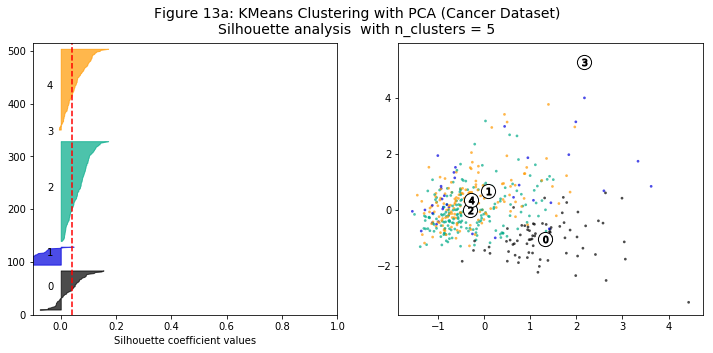

BIC score =  19224.9575078
BIC scores =  [ 20763.79009959  19591.70363752  19390.51811599  19224.95750783
  19457.80402844  19496.92851387  19469.24383444  19541.85621678
  19609.00979609  21590.03025114  21468.1909217   21408.5845514
  21139.67020657  21174.71314426  21376.13921378  21027.87483273
  21127.47421279  21314.55365752  20855.59456087  19708.28729602
  19567.72820064  19579.14718084  19675.5907694   19537.61568639
  19638.52205714  19915.91661452  19860.95916488  21590.03025114
  20038.90175618  20432.00637915  20368.65540949  20666.16383594
  20543.15365407  22069.79416273  22439.42271801  22511.31172037]


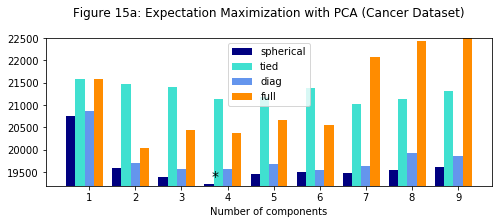

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 'Class'], dtype='object')
For n_clusters = 2 The average silhouette_score is : 0.0938693474496
For n_clusters = 3 The average silhouette_score is : 0.0814808325038
For n_clusters = 4 The average silhouette_score is : 0.0530556110069
For n_clusters = 5 The average silhouette_score is : 0.04733743485


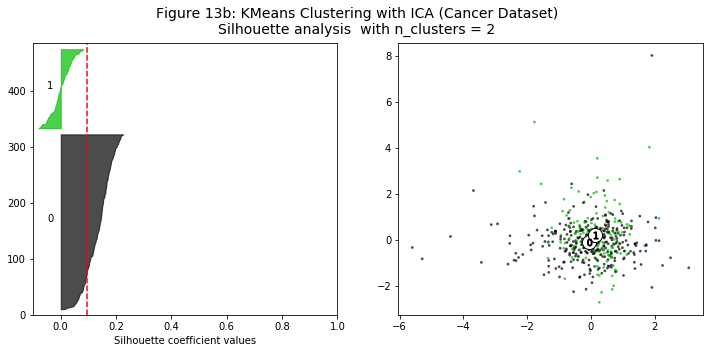

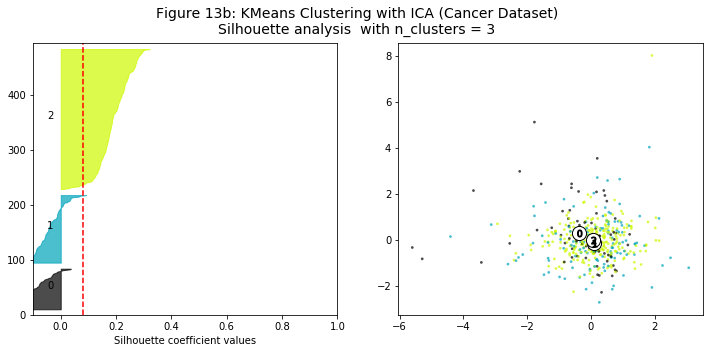

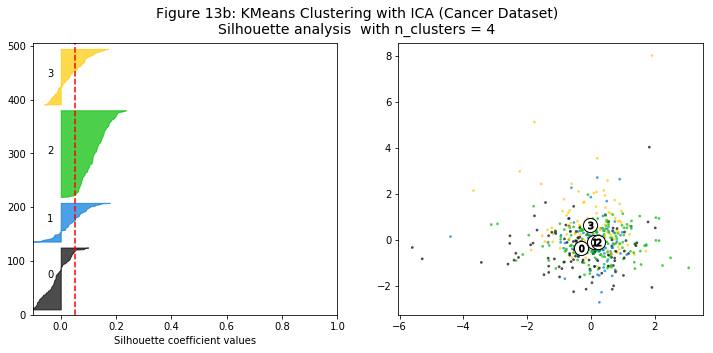

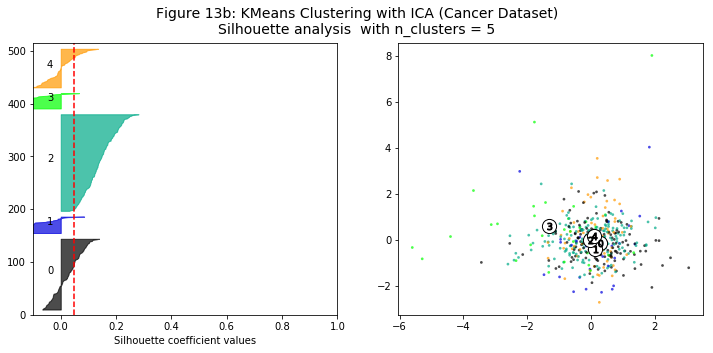

BIC score =  17557.3629567
BIC scores =  [ 19466.43573695  18375.23002641  18181.08615335  18220.98906151
  18225.69858109  18175.78239539  18245.81421637  18263.54038744
  18214.75320742  20194.75112981  20271.9059358   20084.23377763
  19968.65366594  19808.58372012  19546.82105956  19410.97954272
  19918.38109465  19684.33577667  19552.11990082  17908.28697684
  17706.36390624  17557.36295667  17625.79135712  17703.62709953
  17827.23546425  17919.84513081  17868.91567813  20194.75112981
  18838.16697684  19095.71561178  19288.81634309  19925.60181251
  20513.83484677  19952.23758451  19697.03133776  20431.78557304]


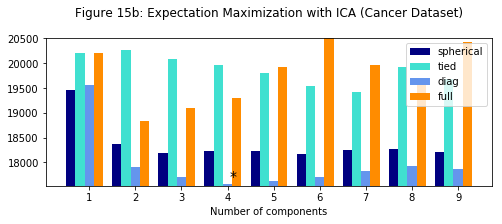

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       'Class'],
      dtype='object')
For n_clusters = 2 The average silhouette_score is : 0.351859939301
For n_clusters = 3 The average silhouette_score is : 0.31703892877
For n_clusters = 4 The average silhouette_score is : 0.189453288036
For n_clusters = 5 The average silhouette_score is : 0.179606786634


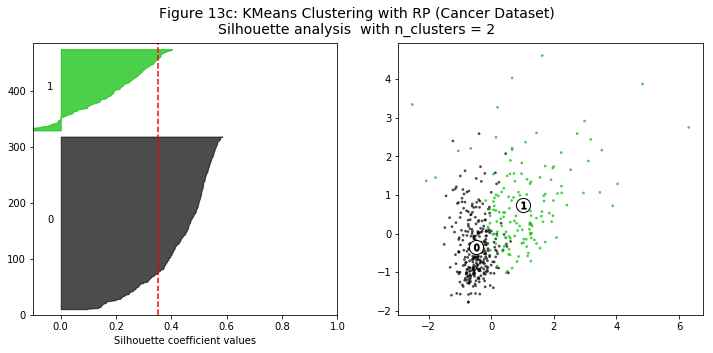

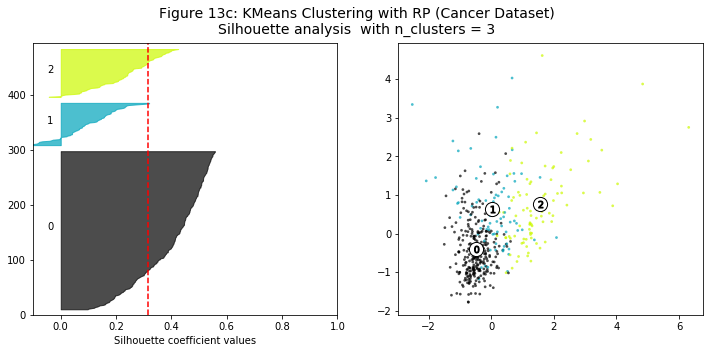

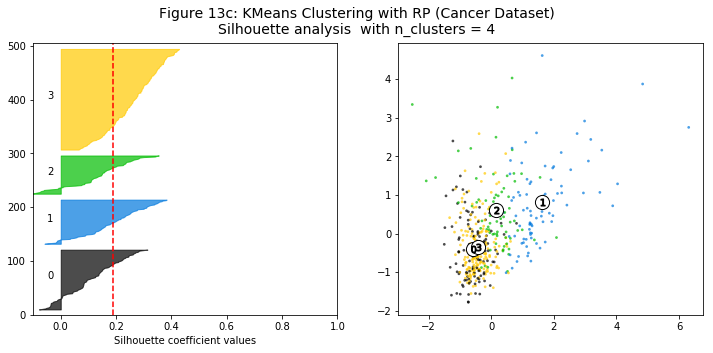

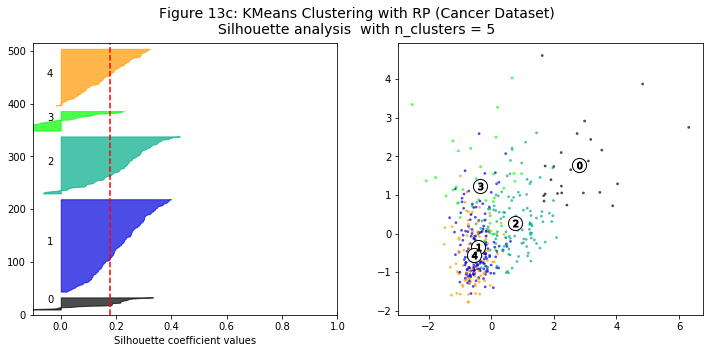

BIC score =  6920.05232358
BIC scores =  [ 24655.85318749  20791.30676827  20054.89574244  19309.40322336
  18702.56588377  18275.9158412   17857.68416382  17683.26308127
  17831.09113708   8904.26151318   8786.61071067   8633.20628969
   8537.0390621    8487.58201852   8494.22398825   8497.87244397
   8425.85894951   8452.98461034  24766.01854103  20514.92780515
  19954.01770031  19438.94210564  18772.84854408  18470.0615724
  18320.16692465  18090.73241525  18339.92103962   8904.26151318
   6920.05232358   7079.79731714   7188.1476088    8250.40040416
   8651.22149015   9280.75144356   8918.36545465  10539.41410842]


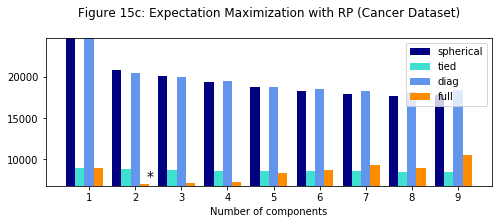

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 'Class'], dtype='object')
For n_clusters = 2 The average silhouette_score is : 0.443863983386
For n_clusters = 3 The average silhouette_score is : 0.310751286619
For n_clusters = 4 The average silhouette_score is : 0.33266284038
For n_clusters = 5 The average silhouette_score is : 0.190139467482


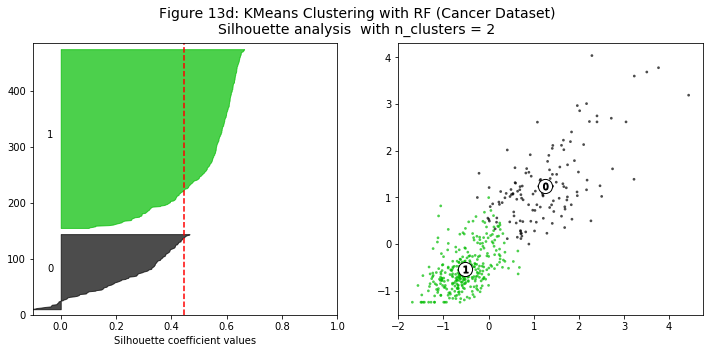

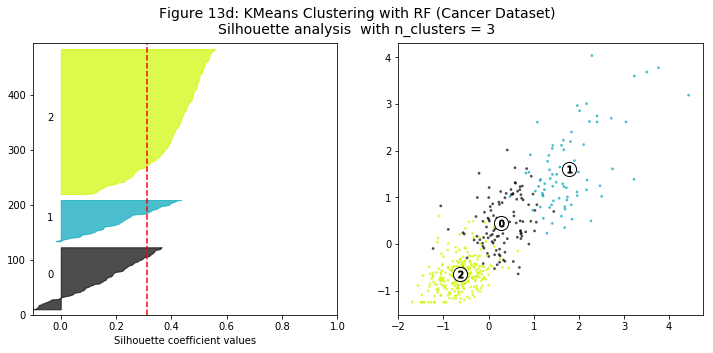

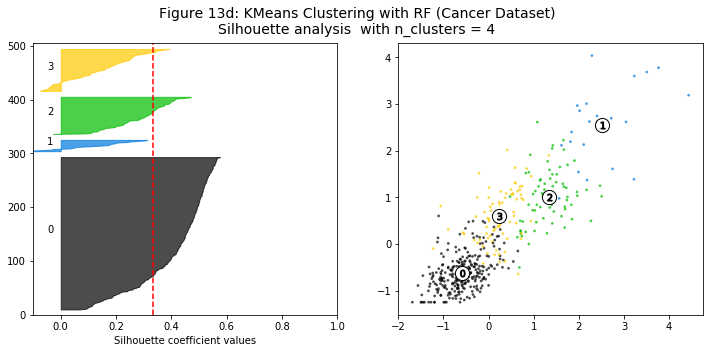

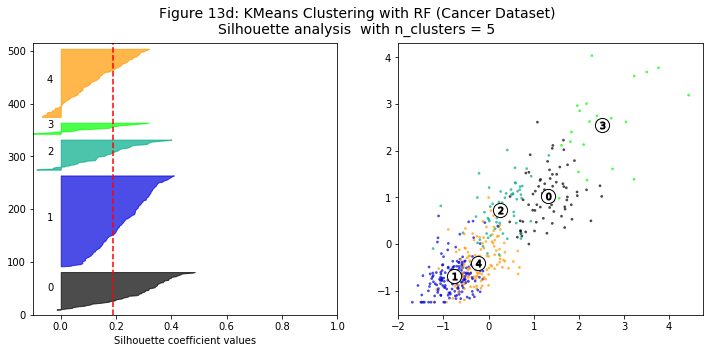

BIC score =  -545.371869479
BIC scores =  [ 23358.49882486  18016.18321167  17059.2989783   16672.76993744
  15954.3249638   15441.54623911  15505.87976249  14854.34077684
  14392.57895122   2935.52362581   2857.29739384   2667.80459153
   2695.80118052   2502.30245431   2322.48990361   2558.55991362
   2418.20304369   2709.27447407  23462.54388098  16552.93511846
  15019.66063013  13842.6625458   13264.5908034   12447.95291715
  12307.388596    12123.19849281  12263.15440226   2935.52362581
   -545.37186948     87.23061089   -311.58482327    271.45991666
    684.05585518   1570.05660016   1608.85881982   2985.67402536]


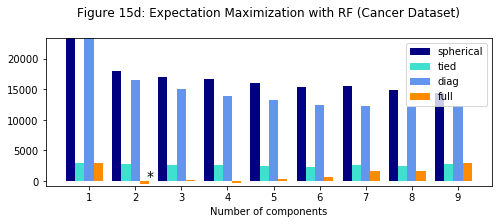

In [147]:
#random.seed(55)
titles = ["Figure 13a: KMeans Clustering with PCA (Cancer Dataset)\n",
          "Figure 13b: KMeans Clustering with ICA (Cancer Dataset)\n",
          "Figure 13c: KMeans Clustering with RP (Cancer Dataset)\n",
          "Figure 13d: KMeans Clustering with RF (Cancer Dataset)\n"]

titles_bic_1 = ["Figure 15a: Expectation Maximization with PCA (Cancer Dataset)\n",
          "Figure 15b: Expectation Maximization with ICA (Cancer Dataset)\n",
          "Figure 15c: Expectation Maximization with RP (Cancer Dataset)\n",
          "Figure 15d: Expectation Maximization with RF (Cancer Dataset)\n"]

titles_bic_2 = "Cluster Representation"

algo_name = ['PCA', 'ICA', 'RP', 'RF']
for i in range(len(algo_name)):
    # load datasets      
    temp = pd.read_hdf('datasets.hdf','cancer_'+algo_name[i]) 
    print(temp.columns)
    tempX = temp.drop('Class',1).copy().values
    tempY = temp['Class'].copy().values
    
    tempX = StandardScaler().fit_transform(tempX)
    
    kmeans_silhoutte(tempX, tempY, titles[i])
    compute_bic_score(tempX , titles_bic_1[i], titles_bic_2)
    

In [143]:
clusters = [2,3]

algo_name = ['PCA', 'ICA', 'RP', 'RF']
for i in range(len(algo_name)):
    # load datasets      
    temp = pd.read_hdf('datasets.hdf','cancer_'+algo_name[i]) 
    print(temp.columns)
    tempX = temp.drop('Class',1).copy().values
    tempY = temp['Class'].copy().values
    
    tempX = StandardScaler().fit_transform(tempX)

    for k in clusters:
        km.set_params(n_clusters=k)
        #gmm.set_params(n_components=k)
    
        km = km.fit(tempX)
        #gmm.fit(X_train)
        #SSE[k]['Cancer'] = km.score(X_train)
        print("Sum of squared distances for ", algo_name[i], " for clusters = ", k , " = ",  km.inertia_)


Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 'Class'], dtype='object')
Sum of squared distances for  PCA  for clusters =  2  =  6951.56403583
Sum of squared distances for  PCA  for clusters =  3  =  6657.22734755
Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 'Class'], dtype='object')
Sum of squared distances for  ICA  for clusters =  2  =  6475.91943272
Sum of squared distances for  ICA  for clusters =  3  =  6216.3174993
Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       'Class'],
      dtype='object')
Sum of squared distances for  RP  for clusters =  2  =  5747.84522365
Sum of squared distances for  RP  for clusters =  3  =  5004.03754139
Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 'Class'], dtype='object')
Sum of squared distances for  RF  for clusters =  2  =  4537.43830888
Sum of squared distances for  RF  for clusters =  3  =  3741.9774612


In [206]:
### Part 5 - NN with Dimension Reduction using PCA, ICA, RP and RF

In [156]:
# Run NN on original dataset without cluster dimension for comparison
nn_arga = [(50)]
nn_lr = [.06]
algo_name = ['PCA', 'ICA', 'RP', 'RF', 'original']

grid ={'learning_rate_init':nn_lr,'hidden_layer_sizes':nn_arga}
mlp = MLPClassifier(max_iter=2000,early_stopping=True,random_state=5)
gs = GridSearchCV(mlp,grid,verbose=10,cv=5)
gs.fit(X_train, Y_train)
tmp = pd.DataFrame(gs.cv_results_)
tmp.to_csv('./Part5/cancer_original.csv')
clf = gs.best_estimator_
print("Original classifier ", clf)
#algo_name.append('original')
clusters =  [1,2,3,4,5,6,7,8,9,10]

# Run NN on dimensionally reduced and original datasets with addition cluster dimension
for i in range(len(algo_name)):
    #for i in range(4,5):
    # load datasets  
    if (i==4):
        tempX = X_train
        tempY = Y_train
    else:
        temp = pd.read_hdf('datasets.hdf','cancer_'+algo_name[i])    
        tempX = temp.drop('Class',1).copy().values
        tempY = temp['Class'].copy().values
     
    km = kmeans(random_state=5)
    gmm = myGMM(random_state=5)

    grid ={'addClustKM__n_clusters':clusters,'NN__learning_rate_init':nn_lr,'NN__hidden_layer_sizes':nn_arga}
    mlp = MLPClassifier(max_iter=2000,early_stopping=True,random_state=5)
    pipe = Pipeline([('addClustKM',appendClusterDimKM(cluster_algo = km)),('NN',mlp)])
    gs = GridSearchCV(pipe,grid,verbose=10,cv=5)
    
    gs.fit(tempX,tempY)
    tmp = pd.DataFrame(gs.cv_results_)
    tmp.to_csv('./Part5/cancer_km_'+algo_name[i]+'.csv')
    
    grid ={'addClustGMM__n_clusters':clusters,'NN__learning_rate_init':nn_lr,'NN__hidden_layer_sizes':nn_arga}
    mlp = MLPClassifier(max_iter=2000,early_stopping=True,random_state=5)
    pipe = Pipeline([('addClustGMM',appendClusterDimGMM(cluster_algo = gmm)),('NN',mlp)])
    gs = GridSearchCV(pipe,grid,verbose=10,cv=5)
    
    gs.fit(tempX,tempY)
    tmp = pd.DataFrame(gs.cv_results_)
    tmp.to_csv('./Part5/cancer_gmm_'+algo_name[i]+'.csv')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] hidden_layer_sizes=50, learning_rate_init=0.06 ..................
[CV]  hidden_layer_sizes=50, learning_rate_init=0.06, score=0.967032967032967, total=   0.0s
[CV] hidden_layer_sizes=50, learning_rate_init=0.06 ..................
[CV]  hidden_layer_sizes=50, learning_rate_init=0.06, score=0.978021978021978, total=   0.0s
[CV] hidden_layer_sizes=50, learning_rate_init=0.06 ..................
[CV]  hidden_layer_sizes=50, learning_rate_init=0.06, score=0.9230769230769231, total=   0.0s
[CV] hidden_layer_sizes=50, learning_rate_init=0.06 ..................
[CV]  hidden_layer_sizes=50, learning_rate_init=0.06, score=1.0, total=   0.0s
[CV] hidden_layer_sizes=50, learning_rate_init=0.06 ..................
[CV]  hidden_layer_sizes=50, learning_rate_init=0.06, score=0.967032967032967, total=   0.0s
Original classifier  MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1, score=0.945054945054945, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1, score=0.967032967032967, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1, score=0.989010989010989, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1, score=0.9666666666666667, total=   0.0s
[CV] NN__hidden

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.967032967032967, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.967032967032967, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.967032967032967, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.9666666666666667, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3, score=0.967391304347826, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3, score=0.9340659340659341, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3, score=0.9560439560439561, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3, score=0.967032967032967, total=   0.1s
[CV] NN__hidde

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=10, score=0.9555555555555556, total=   0.1s
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1, score=0.945054945054945, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1, score=0.967032967032967, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.9565217391304348, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.9560439560439561, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.9560439560439561, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.989010989010989, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.9555555555555556, total=   0.0s
[CV]

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3, score=0.9021739130434783, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3, score=0.9560439560439561, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3, score=0.978021978021978, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3, score=0.989010989010989, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3, score=0.9333333333333333, total=   0.1s
[CV] 

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10, score=0.9666666666666667, total=   0.1s
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1, score=0.9239130434782609, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1, score=0.9560439560439561, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1 


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1, score=0.9340659340659341, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1, score=0.989010989010989, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1, score=0.9222222222222223, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.9130434782608695, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.6373626373626373, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.9340659340659341, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.6s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.978021978021978, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.9, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3, score=0.6304347826086957, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.7s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3, score=0.7142857142857143, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3, score=0.8461538461538461, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3, score=0.9120879120879121, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3, score=0.8888888888888888, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=4 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=4, score=0.7608695652173914, total=   0.1s
[CV] NN__hid

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1, score=0.9222222222222223, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.9239130434782609, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.6593406593406593, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.9120879120879121, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.7252747252747253, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.8222222222222222, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3, score=0.33695652173913043, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3, score=0.3956043956043956, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3, score=0.8681318681318682, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3, score=0.8021978021978022, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3, score=0.5, total=   0.1s
[CV] NN__hidden_l

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10, score=0.8681318681318682, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10, score=0.6777777777777778, total=   0.1s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1, score=0.967032967032967, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1, score=0.978021978021978, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1, score=0.945054945054945, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_cluster

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1, score=0.9444444444444444, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.967391304347826, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.967032967032967, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.978021978021978, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.945054945054945, total=   0.0s
[CV] NN__hidden_

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.9333333333333333, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3, score=0.9347826086956522, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3, score=0.945054945054945, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3, score=0.945054945054945, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3, score=0.978021978021978, total=   0.1s
[CV] NN__hidden

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=10, score=0.945054945054945, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=10, score=0.9222222222222223, total=   0.1s
Fitting 5 folds for each of 10 candidates, totalling 50 fits

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s



[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1, score=0.9347826086956522, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1, score=0.967032967032967, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1, score=0.978021978021978, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1, score=0.945054945054945, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.967032967032967, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.9340659340659341, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.945054945054945, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.9222222222222223, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3, score=0.9456521739130435, total=   0.0s
[CV] 

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10, score=0.9021739130434783, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10, score=0.9560439560439561, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10, score=0.967032967032967, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10, score=0.967032967032967, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10, score=0.8888888888888888, total=   0

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1, score=0.967391304347826, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1, score=0.978021978021978, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1, score=0.978021978021978, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1, score=0.989010989010989, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_cluster

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.967391304347826, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.978021978021978, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.978021978021978, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.989010989010989, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.9222222222222223, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3, score=0.9782608695652174, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3, score=0.978021978021978, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3, score=0.9560439560439561, total=   0.1s
[CV] NN__hidde

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=10, score=0.978021978021978, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=10, score=0.9, total=   0.1s


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1, score=0.967391304347826, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1, score=0.978021978021978, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1, score=0.978021978021978, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1, score=0.989010989010989, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.967032967032967, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.978021978021978, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.989010989010989, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.9222222222222223, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=3, score=0.9565217391304348, total=   0.0s
[CV] N

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=9, score=0.9333333333333333, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10, score=0.967391304347826, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10, score=0.967032967032967, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10, score=0.9560439560439561, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10, score=0.978021978021978, total=   0.1

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=1, score=0.978021978021978, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.978021978021978, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.9560439560439561, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.9010989010989011, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.9560439560439561, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=2, score=0.9340659340659341, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3, score=0.989010989010989, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3, score=0.9560439560439561, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3, score=0.9340659340659341, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3, score=0.9560439560439561, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustKM__n_clusters=3, score=0.9560439560439561, total=   0.1s
[CV] NN__hidd

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1, score=0.978021978021978, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1, score=0.9560439560439561, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1, score=0.9340659340659341, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=1, score=0.9560439560439561, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.978021978021978, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.967032967032967, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.9340659340659341, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.9560439560439561, total=   0.0s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=2, score=0.9230769230769231, total=   0.0s
[CV] 

[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=9, score=0.9560439560439561, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=9 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=9, score=0.9560439560439561, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10, score=0.9560439560439561, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10, score=0.978021978021978, total=   0.1s
[CV] NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10 
[CV]  NN__hidden_layer_sizes=50, NN__learning_rate_init=0.06, addClustGMM__n_clusters=10, score=0.9340659340659341, total=   0.1

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    5.0s finished


In [154]:
class appendClusterDimKM(BaseEstimator, TransformerMixin):
    def __init__(self, cluster_algo, n_clusters = 8):
        self.cluster_algo = cluster_algo
        self.n_clusters = n_clusters
    def transform(self, X, *_):
        self.cluster_algo.set_params(n_clusters=self.n_clusters)
        self.cluster_algo.fit(X)
        returned_instances = pd.DataFrame(np.hstack((X,np.atleast_2d(self.cluster_algo.predict(X)).T)))
        return returned_instances
    def fit(self, *_):
        return self
  
  
class appendClusterDimGMM(BaseEstimator, TransformerMixin):
    def __init__(self, cluster_algo, n_clusters = 2):
        self.cluster_algo = cluster_algo
        self.n_clusters = n_clusters
        
    def transform(self, X, *_):
        self.cluster_algo.set_params(n_components=self.n_clusters)
        self.cluster_algo.fit(X)
        returned_instances = pd.DataFrame(np.hstack((X,np.atleast_2d(self.cluster_algo.predict(X)).T)))
        return returned_instances
    
    def fit(self, *_):
        return self


class myGMM(GMM):
    def transform(self,X):
        return self.predict_proba(X)

In [215]:
algo_name = ['PCA', 'ICA', 'RP', 'RF', 'original']

for i in range(len(algo_name)):
    print("*** KM "+algo_name[i])
    file_name = "./Part5/cancer_km_"+algo_name[i]+".csv"
    df_t = pd.read_csv(file_name, header='infer')
    print(df_t.groupby('param_NN__hidden_layer_sizes')['mean_test_score'].mean())
    
for i in range(len(algo_name)):
    print("*** EM "+algo_name[i])
    file_name = "./Part5/cancer_gmm_"+algo_name[i]+".csv"
    df_t = pd.read_csv(file_name, header='infer')
    print(df_t.groupby('param_NN__hidden_layer_sizes')['mean_test_score'].mean())

print("*** ORIGINAL ")    
df_t = pd.read_csv("./Part5/cancer_original.csv", header='infer')
print(df_t.groupby('param_hidden_layer_sizes')['mean_test_score'].mean())
   

*** KM PCA
param_NN__hidden_layer_sizes
(25, 25)    0.905128
(25,)       0.840659
(50, 50)    0.930525
50          0.926374
Name: mean_test_score, dtype: float64
*** KM ICA
param_NN__hidden_layer_sizes
(25, 25)    0.638217
(25,)       0.626374
(50, 50)    0.660195
50          0.657387
Name: mean_test_score, dtype: float64
*** KM RP
param_NN__hidden_layer_sizes
(25, 25)    0.923077
(25,)       0.934921
(50, 50)    0.932234
50          0.920269
Name: mean_test_score, dtype: float64
*** KM RF
param_NN__hidden_layer_sizes
(25, 25)    0.933333
(25,)       0.929792
(50, 50)    0.948840
50          0.952747
Name: mean_test_score, dtype: float64
*** KM original
param_NN__hidden_layer_sizes
(25, 25)    0.934921
(25,)       0.928449
(50, 50)    0.922466
50          0.890476
Name: mean_test_score, dtype: float64
*** EM PCA
param_NN__hidden_layer_sizes
(25, 25)    0.912576
(25,)       0.842002
(50, 50)    0.931136
50          0.924542
Name: mean_test_score, dtype: float64
*** EM ICA
param_NN__hidd

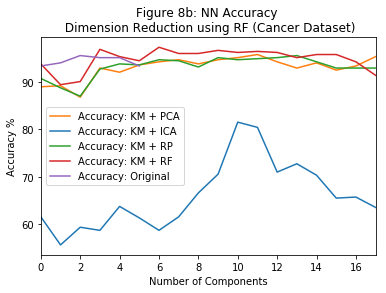

'\nplt.figure(figsize = (12,8))\nfig, ax1 = plt.subplots()\nax1.plot(x_data, df1[1]* 100.0, label = "Feature Importance" , color = "tab:blue",)\nax1.axvline(x=15 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Cluster")\n'

In [121]:
nn_results_km_pca = pd.read_csv("./Part5/cancer_km_PCA.csv", header='infer')
nn_results_km_ica  = pd.read_csv("./Part5/cancer_km_ICA.csv", header='infer')
nn_results_km_rp  = pd.read_csv("./Part5/cancer_km_RP.csv", header='infer')
nn_results_km_rf  = pd.read_csv("./Part5/cancer_km_RF.csv", header='infer')
nn_results_original = pd.read_csv("./Part5/cancer_original.csv", header='infer')



nn_results_km_pca_results = nn_results_km_pca['mean_test_score'] * 100.0
nn_results_km_ica_results = nn_results_km_ica['mean_test_score'] * 100.0
nn_results_km_rp_results = nn_results_km_rp['mean_test_score'] * 100.0
nn_results_km_rf_results = nn_results_km_rf['mean_test_score'] * 100.0
nn_results_km_original_results = nn_results_original['mean_test_score'] * 100.0

#nn_train_results_pca = nn_results['mean_train_score'] * 100.0
nn_results_km_pca_results.plot( color = 'tab:orange',  label = "Accuracy: KM + PCA" )
nn_results_km_ica_results.plot( color = 'tab:blue',  label = "Accuracy: KM + ICA" )
nn_results_km_rp_results.plot( color = 'tab:green',  label = "Accuracy: KM + RP" )
nn_results_km_rf_results.plot( color = 'tab:red',  label = "Accuracy: KM + RF" )
nn_results_km_original_results.plot( color = 'tab:purple',  label = "Accuracy: Original" )

#plt.axvline(x=21 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Components (n=21)")

plt.legend(loc='best')
plt.title("Figure 8b: NN Accuracy \n Dimension Reduction using RF (Cancer Dataset)")
plt.xlabel("Number of Components")
plt.ylabel("Accuracy %");
plt.show()
plt.close()

#clf = gs.best_estimator_
## test score

#test_score = clf.score(X_test, Y_test)
#print("Test Accuracy = ", test_score )
#print("Best Estimator = ", clf)
#x_data = df1[0] 

'''
plt.figure(figsize = (12,8))
fig, ax1 = plt.subplots()
ax1.plot(x_data, df1[1]* 100.0, label = "Feature Importance" , color = "tab:blue",)
ax1.axvline(x=15 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Cluster")
'''